In [1]:
#!pip install pandas --upgrade  --quiet
#!pip install numpy --upgrade  --quiet
#!pip install scipy --upgrade  --quiet
#!pip install statsmodels --upgrade  --quiet
#!pip install scikit-learn --upgrade  --quiet
#!pip install missingno --upgrade  --quiet
#!pip install torch --upgrade --quiet
!pip install apafib --upgrade --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Objetivos de aprendizaje:
1. Conocer las arquitecturas de perceptrón multicapa y redes convolucionales
2. Conocer las funciones de error según el tipo de tarea de un problema
3. Experimentar con diferentes configuraciones para una red y saberlas ajustar para diferentes tipos de problemas

# Problema 4: Ajuste de salario
En problemas de regresión habitualmente asumimos que hay una parte estocástica en el valor que estimamos que sigue una distribución que tiene una varianza fija. Esto es conocido como homocedasticidad. En la realidad esto no tiene por qué ser cierto y hay problemas en los que la variablidad del ruido depende del dato específico que predecimos, tenemos en este caso heterocedasticidad. Esto se puede capturar mejor si usamos modelos que pueden adaptarse a este ruido cambiante. Vamos a utilizar una versión de un conjunto de datos de salarios que se utiliza habitualmente en libros de econometría para ilustrar este fenómeno. Podéis obtenerlo mediante
la librería apafib empleando la función load_wages. El objetivo es predecir la variable $wage$ usando el resto, que corresponden a variables socioeconómicas. Para resolver los siguientes apartados tienes un notebook con una serie de funciones que te servirán para resolverlos.

## Imports y código dado para el problema

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

from time import time
from datetime import timedelta

init_time = time()

In [3]:
import pandas as pd
import numpy as np
from numpy.random import choice
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import set_config
from sklearn.metrics import ConfusionMatrixDisplay, classification_report,  RocCurveDisplay, PrecisionRecallDisplay, accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from yellowbrick.classifier.rocauc import roc_auc
from yellowbrick.target.feature_correlation import feature_correlation
from yellowbrick.classifier import precision_recall_curve
from tqdm.notebook import tqdm
from torch.utils.data import Dataset
from scipy import stats
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

from apafib import load_wages

import warnings
set_config(display='text')
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 16})
pd.set_option('display.precision', 3)

In [4]:
SEED = 3011
# Para reproducibilidad
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
def save_results(clf, X_test, y_test, nclf, df):
    if hasattr(clf, 'best_score_'):
        df.loc[nclf,'train XV acc'] = clf.best_score_
    else:
        df.loc[nclf,'train XV acc'] = np.nan
    df.loc[nclf,'test acc'] = accuracy_score(y_test, clf.predict(X_test))
    df.loc[nclf,'precision score (M)'] = precision_score(y_test, clf.predict(X_test), average='macro')
    df.loc[nclf,'recall score (M)'] = recall_score(y_test, clf.predict(X_test), average='macro')
    df.loc[nclf,'f1 score (M)'] = f1_score(y_test, clf.predict(X_test), average='macro')
    return df

results_df = pd.DataFrame()

In [6]:
class wagesDataset(Dataset):

    def __init__(self, data, labels):
        self.data = torch.Tensor(data).float()
        self.labels = torch.Tensor(labels).float()

    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]

        return x, y

    def __len__(self):
        return len(self.data)

# wages_train = torch.utils.data.DataLoader(wagesDataset(X_train, y_train), batch_size=32)

In [7]:
def RegressionLoss(y, y_hat):
    """ Heteroscedastic regression loss

    y: valores reales (batch_size,)
    y_hat: valores predichos (batch_size, 2)
    """
    mean = y_hat[:, 0]
    logvar = y_hat[:, 1]
    square = (mean - y).square()
    sigsq = (logvar.exp() + 1e-5)
    ms = (square / sigsq + logvar)
    return ms.mean()

In [8]:
# Funcion para entrenar el modelo
def train_loop(model, train, val, optimizer, scheduler=None, patience=5, epochs=100, lossf=F.mse_loss):
    """_Bucle de entrenamiento_

    Args:
        model: red a entrenar
        optimizer: optimizador de pytorch, por ejemplo torch.optim.Adam
        train: datos de entrenamiento
        val: datos de validacion
        epochs: numero de epochs

    Returns:
        _type_: _description_
    """
    def epoch_loss(dataset):
        data_loss = 0.0
        for i, (data, labels) in enumerate(dataset):
            inputs = data.to('cuda')
            y = labels.to('cuda')
            outputs = model(inputs)
            loss = lossf(y, outputs)
            data_loss += loss.item()
        return data_loss/i

    def early_stopping(val_loss, patience=5):
        if len(val_loss) > patience:
            if val_loss[-1] > np.mean(val_loss[-(patience+1):-1]):
                return True

    hist_loss = {'train': [], 'val': []}
    pbar = tqdm(range(epochs))
    for epoch in pbar:  # bucle para todos los epochs
        for i, (data, labels) in enumerate(train):
            # obtenemos los datos y los subimos a la GPU
            inputs = data.to('cuda')
            y = labels.to('cuda')

            # Reiniciamos los gradientes
            optimizer.zero_grad()

            # Aplicamos los datos al modelo
            outputs = model(inputs)
            # Calculamos la perdida
            loss = lossf(y, outputs)

            # Hacemos el paso hacia atras
            loss.backward()
            optimizer.step()

        if scheduler is not None:
            scheduler.step()

        # Calculamos la perdida en el conjunto de entrenamiento y validacion
        with torch.no_grad():
            hist_loss['train'].append(epoch_loss(train))
            hist_loss['val'].append(epoch_loss(val))

        # Mostramos la perdida en el conjunto de entrenamiento y validacion
        pbar.set_postfix({'train': hist_loss['train'][-1], 'val': hist_loss['val'][-1]})

        # Si la perdida en el conjunto de validacion no disminuye, paramos el entrenamiento
        if early_stopping(hist_loss['val'], patience):
            break

    return hist_loss

# Para el optimizador podemos usar Adam, le pasaremos el siguiente objeto
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# donde model es el modelo que queremos entrenar
# y lr es la tasa de aprendizaje, 1e-4 es un valor comun

In [9]:
# Clase para definir la arquitectura del MLP
class MLPRegressor(nn.Module):

    def __init__(self, input_size, hidden_layers_sizes, activation = nn.ReLU, var = True):
        super(MLPRegressor, self).__init__()
        self.layers = []
        self.fc1 = nn.Linear(input_size, hidden_layers_sizes[0])
        self.layers.append(self.fc1)
        self.layers.append(activation())
        for i in range(1, len(hidden_layers_sizes)):
            self.layers.append(
                nn.Linear(hidden_layers_sizes[i - 1], hidden_layers_sizes[i]))
            self.layers.append(activation())
        self.layers = nn.Sequential(*self.layers)
        if var:
            self.output = nn.Linear(hidden_layers_sizes[-1], 2)
        else:
            self.output = nn.Linear(hidden_layers_sizes[-1], 1)
    def forward(self, x):
        return self.output(self.layers(x.view(x.size(0), -1)))

In [10]:
def test_model(model, test):
    """_Funcion para obtener las predicciones de un modelo en un conjunto de test_

    Poner el modelo en modo evaluacion antes de llamar a esta funcion

    Args:
        model: _modelo entrenado_
        test: _conjunto de test_

    Returns:
        _type_: _valores predichos, valores reales_
    """
    preds = []
    true = []
    for X, Y in test:
        X = X.to('cuda')
        y_pred = model(X)
        preds.append(y_pred.detach().cpu().numpy())
        true.append(Y.cpu().numpy())
    return np.concatenate(preds), np.concatenate(true)

## Funciones auxiliares propias

In [11]:
# Grafica curvas de aprendizaje de entrenamiento y validación
def plot_curvas_aprendizaje(hist_loss, model_name):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Pérdida vs épocas
    axes[0].plot(hist_loss['train'], label = 'Train', linewidth = 2)
    axes[0].plot(hist_loss['val'], label = 'Validation', linewidth = 2)
    axes[0].set_xlabel('Época')
    axes[0].set_ylabel('Pérdida')
    axes[0].set_title(f'Curvas de Aprendizaje - {model_name}')
    axes[0].legend()
    axes[0].grid(True, alpha = 0.3)

    # Pérdida en escala logarítmica
    axes[1].semilogy(hist_loss['train'], label = 'Train', linewidth = 2)
    axes[1].semilogy(hist_loss['val'], label = 'Validation', linewidth = 2)
    axes[1].set_xlabel('Época')
    axes[1].set_ylabel('Pérdida (log)')
    axes[1].set_title(f'Pérdida en Escala Logarítmica - {model_name}')
    axes[1].legend()
    axes[1].grid(True, alpha = 0.3)

    plt.tight_layout()
    plt.show()

In [12]:
# Grafica residuos
def plot_residuals(y_true, y_pred, model_name, X_test):
    residuals = y_true - y_pred

    fig, axes = plt.subplots(2, 3, figsize = (18, 10))

    axes[0, 0].scatter(y_pred, residuals, alpha = 0.5, s = 20)
    axes[0, 0].axhline(y = 0, color = 'r', linestyle = '--', linewidth = 2)
    axes[0, 0].set_xlabel('Predicciones')
    axes[0, 0].set_ylabel('Residuos')
    axes[0, 0].set_title(f'Residuos vs Predicciones\n{model_name}')
    axes[0, 0].grid(True, alpha = 0.3)

    axes[0, 1].hist(residuals, bins = 30, edgecolor = 'black', density = True)
    axes[0, 1].axvline(x = 0, color = 'r', linestyle = '--', linewidth = 2)
    axes[0, 1].set_xlabel('Residuos')
    axes[0, 1].set_ylabel('Densidad')
    axes[0, 1].set_title(f'Distribución de Residuos\n{model_name}')
    axes[0, 1].grid(True, alpha = 0.3)

    stats.probplot(residuals.flatten(), dist = "norm", plot = axes[0, 2])
    axes[0, 2].set_title(f'QQ-Plot de Residuos\n{model_name}')
    axes[0, 2].grid(True, alpha = 0.3)

    if X_test is not None:
        axes[1, 0].scatter(X_test[:, continuas.index('exper')], residuals, alpha = 0.5, s = 20)
        axes[1, 0].axhline(y = 0, color = 'r', linestyle = '--', linewidth = 2)
        axes[1, 0].set_xlabel('exper (años experiencia)')
        axes[1, 0].set_ylabel('Residuos')
        axes[1, 0].set_title(f'Residuos vs Experiencia\n{model_name}')
        axes[1, 0].grid(True, alpha = 0.3)

        axes[1, 1].scatter(X_test[:, continuas.index('age')], residuals, alpha = 0.5, s = 20)
        axes[1, 1].axhline(y = 0, color = 'r', linestyle = '--', linewidth = 2)
        axes[1, 1].set_xlabel('age (edad)')
        axes[1, 1].set_ylabel('Residuos')
        axes[1, 1].set_title(f'Residuos vs Edad\n{model_name}')
        axes[1, 1].grid(True, alpha = 0.3)

    axes[1, 2].scatter(y_true, y_pred, alpha = 0.5, s = 20)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    axes[1, 2].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth = 2)
    axes[1, 2].set_xlabel('Valores Reales')
    axes[1, 2].set_ylabel('Predicciones')
    axes[1, 2].set_title(f'Predicciones vs Reales\n{model_name}')
    axes[1, 2].grid(True, alpha = 0.3)

    plt.tight_layout()
    plt.show()

    print(f"\nESTADÍSTICAS DE RESIDUOS - {model_name}:")
    print(f"Media de residuos: {residuals.mean():.4f}")
    print(f"Desviación estándar de residuos: {residuals.std():.4f}")
    print(f"Máximo residuo: {residuals.max():.4f}")
    print(f"Mínimo residuo: {residuals.min():.4f}")
    print(f"Residuos positivos: {(residuals > 0).sum()}/{len(residuals)}")
    print(f"Residuos negativos: {(residuals < 0).sum()}/{len(residuals)}")

In [32]:
# Grafica predicciones en función de los valores de variables
def plot_predictions_vs_variables(X_test, y_true, y_pred, model_name, variable_names):
    fig, axes = plt.subplots(1, len(variable_names), figsize = (14, 5))

    for idx, var_name in enumerate(variable_names):
        var_idx = 0
        for i, v in enumerate(wages.columns):
            if v == var_name:
                var_idx = i - 1

        axes[idx].scatter(X_test[:, var_idx], y_true, alpha = 0.3, s = 20, label = 'Real', color = 'blue')
        axes[idx].scatter(X_test[:, var_idx], y_pred, alpha = 0.3, s = 20, label = 'Predicho', color = 'red')

        axes[idx].set_xlabel(var_name)
        axes[idx].set_ylabel('wage')
        axes[idx].set_title(f'Predicciones vs {var_name}\n{model_name}')
        axes[idx].legend(loc = 'best')
        axes[idx].grid(True, alpha = 0.3)

    plt.tight_layout()
    plt.show()

In [14]:
# Analizar overfitting (comparando train vs validation loss)
def analyze_overfitting(model_info, model_name, threshold_percent):
    # Obtener métricas de validación y test
    mae_val = model_info['val_mae']
    mse_val = model_info['val_mse']
    mae_test = model_info['test_mae']
    mse_test = model_info['test_mse']
    diff_mae = mae_test - mae_val
    diff_mse = mse_test - mse_val
    diff_percent_mae = (diff_mae / mae_val) * 100
    diff_percent_mse = (diff_mse / mse_val) * 100

    print(f"\n" + "="*60)
    print(f"ANÁLISIS DE SOBRE-ESPECIALIZACIÓN - {model_name}")
    print("="*60)
    print("(comparación VALIDACIÓN vs TEST)")
    print("-"*60)

    print(f"\nMÉTRICAS DE RENDIMIENTO:")
    print(f"{'Métrica':<15} {'Validación':<12} {'Test':<12} {'Diferencia':<12} {'% Diferencia':<12}")
    print(f"{'-'*15:<15} {'-'*12:<12} {'-'*12:<12} {'-'*12:<12} {'-'*12:<12}")
    print(f"{'MAE':<15} {mae_val:<12.4f} {mae_test:<12.4f} {diff_mae:<12.4f} {diff_percent_mae:<12.1f}%")
    print(f"{'MSE':<15} {mse_val:<12.4f} {mse_test:<12.4f} {diff_mse:<12.4f} {diff_percent_mse:<12.1f}%")

    # Criterios de sobre-especialización según enunciado
    print(f"\nDIAGNÓSTICO DE SOBRE-ESPECIALIZACIÓN:")

    if diff_percent_mae > threshold_percent:
        print(f"❌ ALERTA SOBRE-ESPECIALIZACIÓN: MAE en test es {diff_percent_mae:.1f}% mayor que en validación")
        print(f"   El modelo se ha especializado demasiado en los datos de validación.")
        print(f"   No generaliza bien a datos completamente nuevos (test).")
    elif diff_percent_mae > threshold_percent/2:
        print(f"⚠️  POSIBLE SOBRE-ESPECIALIZACIÓN MODERADA: +{diff_percent_mae:.1f}%")
        print(f"   El modelo puede estar empezando a sobreajustarse.")
    elif diff_percent_mae < -threshold_percent/2:
        print(f"⚠️  COMPORTAMIENTO INUSUAL: test mejor que validación ({diff_percent_mae:.1f}%)")
        print(f"   Puede deberse a variabilidad aleatoria o que test es más 'fácil'.")
    else:
        print(f"✅ BUENA GENERALIZACIÓN: diferencia mínima ({diff_percent_mae:.1f}%)")
        print(f"   El modelo generaliza bien a datos no vistos durante entrenamiento.")

    # Visualización
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Gráfico 1: Comparación MAE/MSE
    metrics = ['MAE', 'MSE']
    val_values = [mae_val, mse_val]
    test_values = [mae_test, mse_test]

    x = np.arange(len(metrics))
    width = 0.35

    axes[0].bar(x - width/2, val_values, width, label='Validación', color='blue', alpha=0.7)
    axes[0].bar(x + width/2, test_values, width, label='Test', color='red', alpha=0.7)

    axes[0].set_xlabel('Métrica')
    axes[0].set_ylabel('Valor')
    axes[0].set_title('Comparación Validación vs Test')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(metrics)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3, axis='y')

    # Añadir valores encima de las barras
    for i, (v, t) in enumerate(zip(val_values, test_values)):
        axes[0].text(i - width/2, v, f'{v:.2f}', ha='center', va='bottom')
        axes[0].text(i + width/2, t, f'{t:.2f}', ha='center', va='bottom')

    # Gráfico 2: Diferencia porcentual
    diffs = [diff_percent_mae, diff_percent_mse]
    colors = ['red' if d > threshold_percent else 'orange' if d > threshold_percent/2 else 'green' for d in diffs]

    bars = axes[1].bar(metrics, diffs, color=colors, alpha=0.7)
    axes[1].axhline(y=threshold_percent, color='r', linestyle='--', alpha=0.5, label=f'Umbral ({threshold_percent}%)')
    axes[1].axhline(y=threshold_percent/2, color='orange', linestyle='--', alpha=0.5, label=f'Advertencia ({threshold_percent/2}%)')
    axes[1].axhline(y=0, color='black', linewidth=0.5)

    axes[1].set_xlabel('Métrica')
    axes[1].set_ylabel('Diferencia % (Test - Validación)')
    axes[1].set_title('Porcentaje de Deterioro en Test')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, axis='y')

    # Añadir valores en las barras
    for bar, diff in zip(bars, diffs):
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2, height, f'{diff:.1f}%',
                    ha='center', va='bottom' if height > 0 else 'top')

    plt.tight_layout()
    plt.show()

    return diff_percent_mae, diff_percent_mse

A continuación, cargamos los datos, y realizamos una mínima exploración para ver las dimensiones de estos, así como los missing values y la distribución de la variable objetivo.

Dimensiones: (4838, 21)

Tipos de variables:
int64      20
float64     1
Name: count, dtype: int64

Missing values de cada columna:
wage         0
educ         0
exper        0
fulltime     0
hrswk        0
nkids        0
age          0
married      0
female       0
insurance    0
private      0
mcaid        0
mcare        0
metro        0
northeast    0
midwest      0
south        0
west         0
white        0
black        0
asian        0
dtype: int64

Matriz de correlaciones:


<Figure size 1200x800 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Matriz de Correlación - Variables del Dataset')

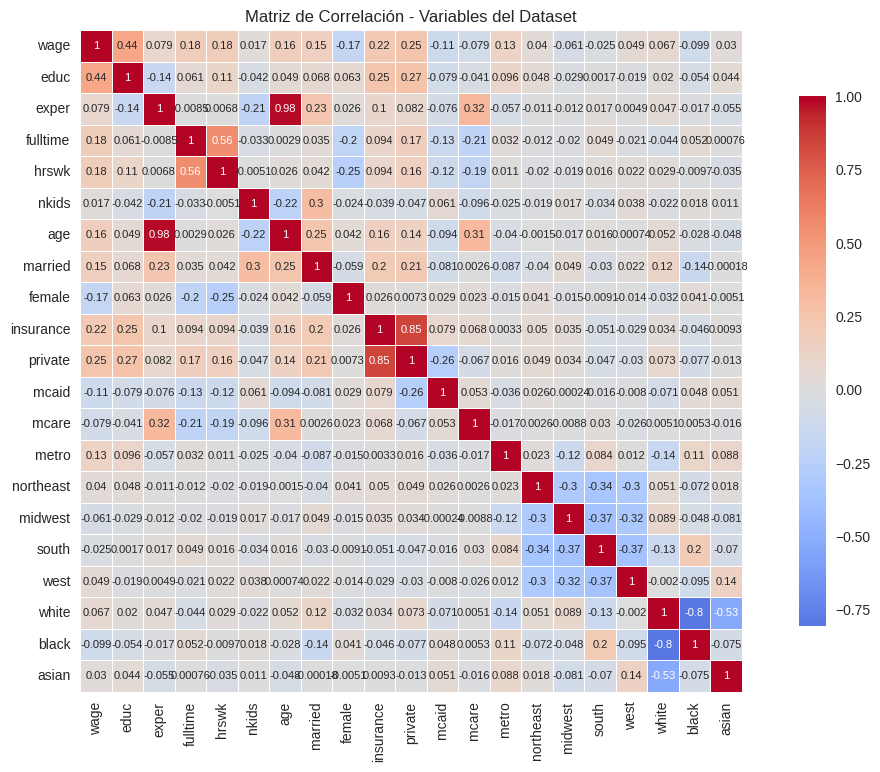


Distribuciones de las variables:


<Figure size 1800x3000 with 0 Axes>

<Axes: >

<Axes: xlabel='educ', ylabel='Count'>

Text(0.5, 1.0, 'Distribución de educ')

<Axes: >

<Axes: xlabel='exper', ylabel='Count'>

Text(0.5, 1.0, 'Distribución de exper')

<Axes: >

<Axes: xlabel='fulltime', ylabel='Count'>

Text(0.5, 1.0, 'Distribución de fulltime')

<Axes: >

<Axes: xlabel='hrswk', ylabel='Count'>

Text(0.5, 1.0, 'Distribución de hrswk')

<Axes: >

<Axes: xlabel='nkids', ylabel='Count'>

Text(0.5, 1.0, 'Distribución de nkids')

<Axes: >

<Axes: xlabel='age', ylabel='Count'>

Text(0.5, 1.0, 'Distribución de age')

<Axes: >

<Axes: xlabel='married', ylabel='Count'>

Text(0.5, 1.0, 'Distribución de married')

<Axes: >

<Axes: xlabel='female', ylabel='Count'>

Text(0.5, 1.0, 'Distribución de female')

<Axes: >

<Axes: xlabel='insurance', ylabel='Count'>

Text(0.5, 1.0, 'Distribución de insurance')

<Axes: >

<Axes: xlabel='private', ylabel='Count'>

Text(0.5, 1.0, 'Distribución de private')

<Axes: >

<Axes: xlabel='mcaid', ylabel='Count'>

Text(0.5, 1.0, 'Distribución de mcaid')

<Axes: >

<Axes: xlabel='mcare', ylabel='Count'>

Text(0.5, 1.0, 'Distribución de mcare')

<Axes: >

<Axes: xlabel='metro', ylabel='Count'>

Text(0.5, 1.0, 'Distribución de metro')

<Axes: >

<Axes: xlabel='northeast', ylabel='Count'>

Text(0.5, 1.0, 'Distribución de northeast')

<Axes: >

<Axes: xlabel='midwest', ylabel='Count'>

Text(0.5, 1.0, 'Distribución de midwest')

<Axes: >

<Axes: xlabel='south', ylabel='Count'>

Text(0.5, 1.0, 'Distribución de south')

<Axes: >

<Axes: xlabel='west', ylabel='Count'>

Text(0.5, 1.0, 'Distribución de west')

<Axes: >

<Axes: xlabel='white', ylabel='Count'>

Text(0.5, 1.0, 'Distribución de white')

<Axes: >

<Axes: xlabel='black', ylabel='Count'>

Text(0.5, 1.0, 'Distribución de black')

<Axes: >

<Axes: xlabel='asian', ylabel='Count'>

Text(0.5, 1.0, 'Distribución de asian')

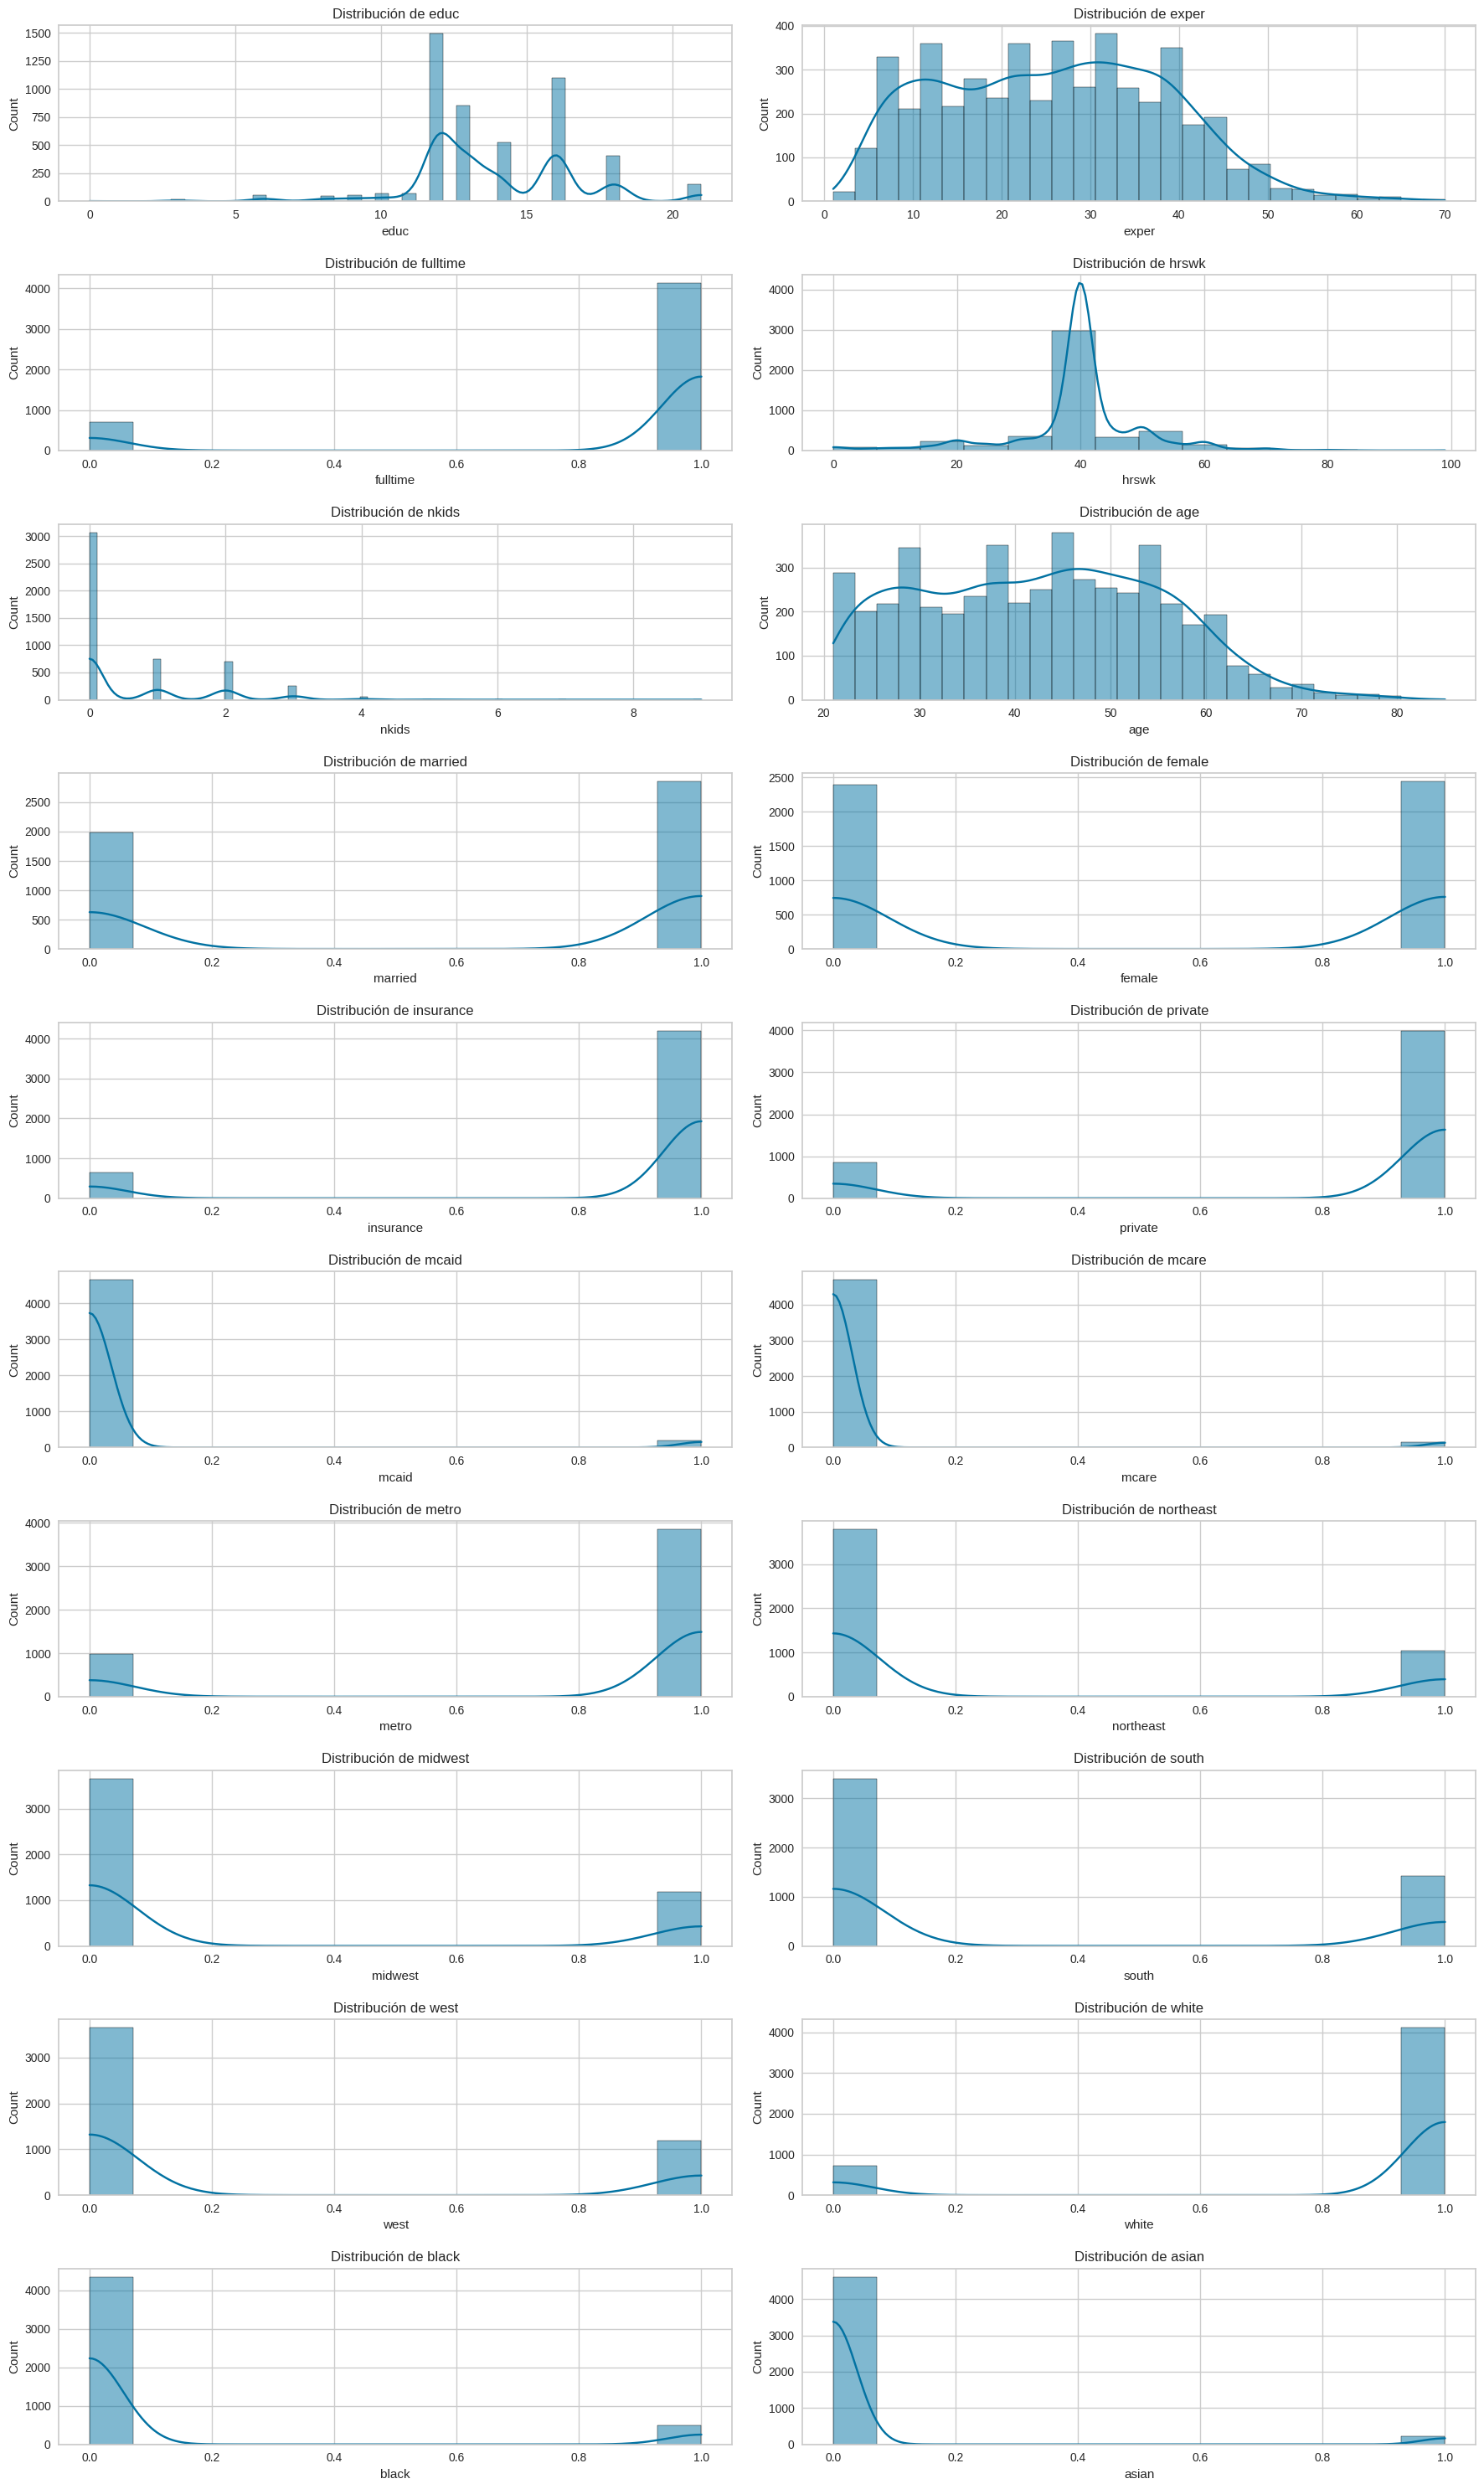


Distribución de la variable objetivo:


<Axes: xlabel='wage', ylabel='Count'>

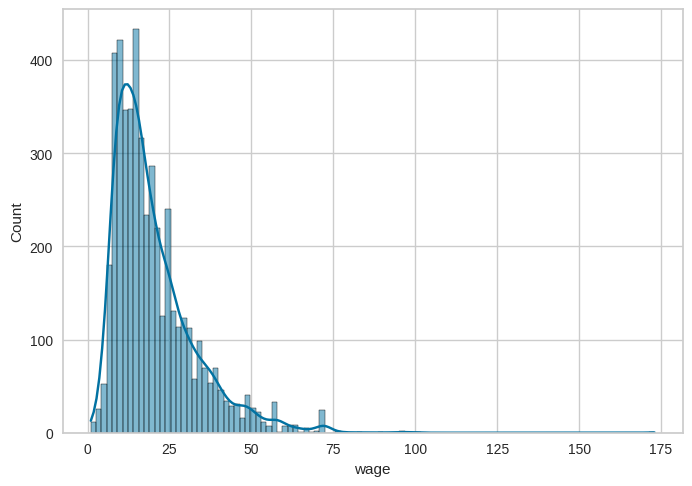


Cabecera del dataset:


wage  educ  exper  fulltime  hrswk  nkids  age  married  female  \
0  18.70    16     39         1     37      0   58        1       1   
1  11.50    12     16         1     62      2   31        0       0   
2  15.04    16     13         1     40      0   32        1       0   
3  25.95    14     11         1     40      3   29        0       1   
4  24.03    12     51         1     40      0   66        1       0   

   insurance  ...  mcaid  mcare  metro  northeast  midwest  south  west  \
0          1  ...      0      0      1          0        0      1     0   
1          0  ...      0      0      0          0        1      0     0   
2          1  ...      0      0      1          0        0      0     1   
3          1  ...      0      0      1          0        0      1     0   
4          1  ...      0      0      1          1        0      0     0   

   white  black  asian  
0      1      0      0  
1      1      0      0  
2      0      1      0  
3      0      1      0  
4      1      0      0  

[5 rows x 21 columns]

In [15]:
wages = load_wages()
print(f"Dimensiones: {wages.shape}")
print(f"\nTipos de variables:")
print(wages.dtypes.value_counts())
print(f"\nMissing values de cada columna:")
print(wages.isnull().sum())
print(f"\nMatriz de correlaciones:")
plt.figure(figsize=(12, 8))
sns.heatmap(wages.corr(), cmap = 'coolwarm', center = 0, square = True, linewidths = 0.5, cbar_kws = {"shrink": 0.8}, annot = True, annot_kws = {'size': 8})
plt.title('Matriz de Correlación - Variables del Dataset')
plt.tight_layout()
plt.show()
print(f"\nDistribuciones de las variables:")
plt.figure(figsize = (18, 30))
for i, col in enumerate(wages.drop('wage', axis = 1).columns, 1):
    plt.subplot(10, 2, i)
    sns.histplot(wages[col], kde = True)
    plt.title(f"Distribución de {col}")
plt.tight_layout()
plt.show()
print(f"\nDistribución de la variable objetivo:")
sns.histplot(wages['wage'], kde = True)
plt.show()
print(f"\nCabecera del dataset:")
wages.head()

Vemos que todas las variables son numéricas (20 enteras y 1 decimal), y que no hay ningun missing value, así que no tendremos que imputar los valores perdidos. Además, podemos ver que no parece haber correlaciones claras entre la variable objetivo $wage$ y el resto de variables (su mayor correlación es 0.44 con la variable $educ$.

## a)
### Vamos a dividir el conjunto de datos en tres partes, el conjunto de entrenamiento (80 %), el conjunto de validación (10 %) y el conjunto de test (10 %). En este caso el ajuste de hiperparámetros y la calidad del modelo se obtendrá mediante el conjunto de validación y comprobaremos la sobre especialización con el conjunto de test (que no se ha usado en ningún momento para tomar decisiones sobre el modelo).

In [16]:
X = wages.drop('wage', axis = 1)
Y = wages['wage']

X_train, X_rest, Y_train, Y_rest = train_test_split(X, Y, test_size = 0.2, random_state = 22)
X_validation, X_test, Y_validation, Y_test = train_test_split(X_rest, Y_rest, test_size = 0.5, random_state = 22)

print(f"Dimensiones de train: {X_train.shape}. Dimensiones de validation: {X_validation.shape}. Dimensiones de test: {X_test.shape}")

Dimensiones de train: (3870, 20). Dimensiones de validation: (484, 20). Dimensiones de test: (484, 20)


Vemos que las dimensiones de los conjuntos son correctas, de forma que en train hay el 80% de los datos, en validation el 10% y en test el 10% restante.

### Comprueba la diferente variabilidad de la variable objetivo representándola respecto a las variables del conjunto de datos que no son discretas, ni ordenadas. Fíjate especialmente en las variables que deberían tener una relación creciente con el salario.

Variables continuas: 
['educ', 'exper', 'hrswk', 'nkids', 'age']


<Figure size 1800x1200 with 0 Axes>

<Axes: >

<Axes: xlabel='educ', ylabel='wage'>

<Axes: xlabel='educ', ylabel='wage'>

Text(0.5, 1.0, 'Wage vs educ')

<Axes: >

<Axes: xlabel='exper', ylabel='wage'>

<Axes: xlabel='exper', ylabel='wage'>

Text(0.5, 1.0, 'Wage vs exper')

<Axes: >

<Axes: xlabel='hrswk', ylabel='wage'>

<Axes: xlabel='hrswk', ylabel='wage'>

Text(0.5, 1.0, 'Wage vs hrswk')

<Axes: >

<Axes: xlabel='nkids', ylabel='wage'>

<Axes: xlabel='nkids', ylabel='wage'>

Text(0.5, 1.0, 'Wage vs nkids')

<Axes: >

<Axes: xlabel='age', ylabel='wage'>

<Axes: xlabel='age', ylabel='wage'>

Text(0.5, 1.0, 'Wage vs age')

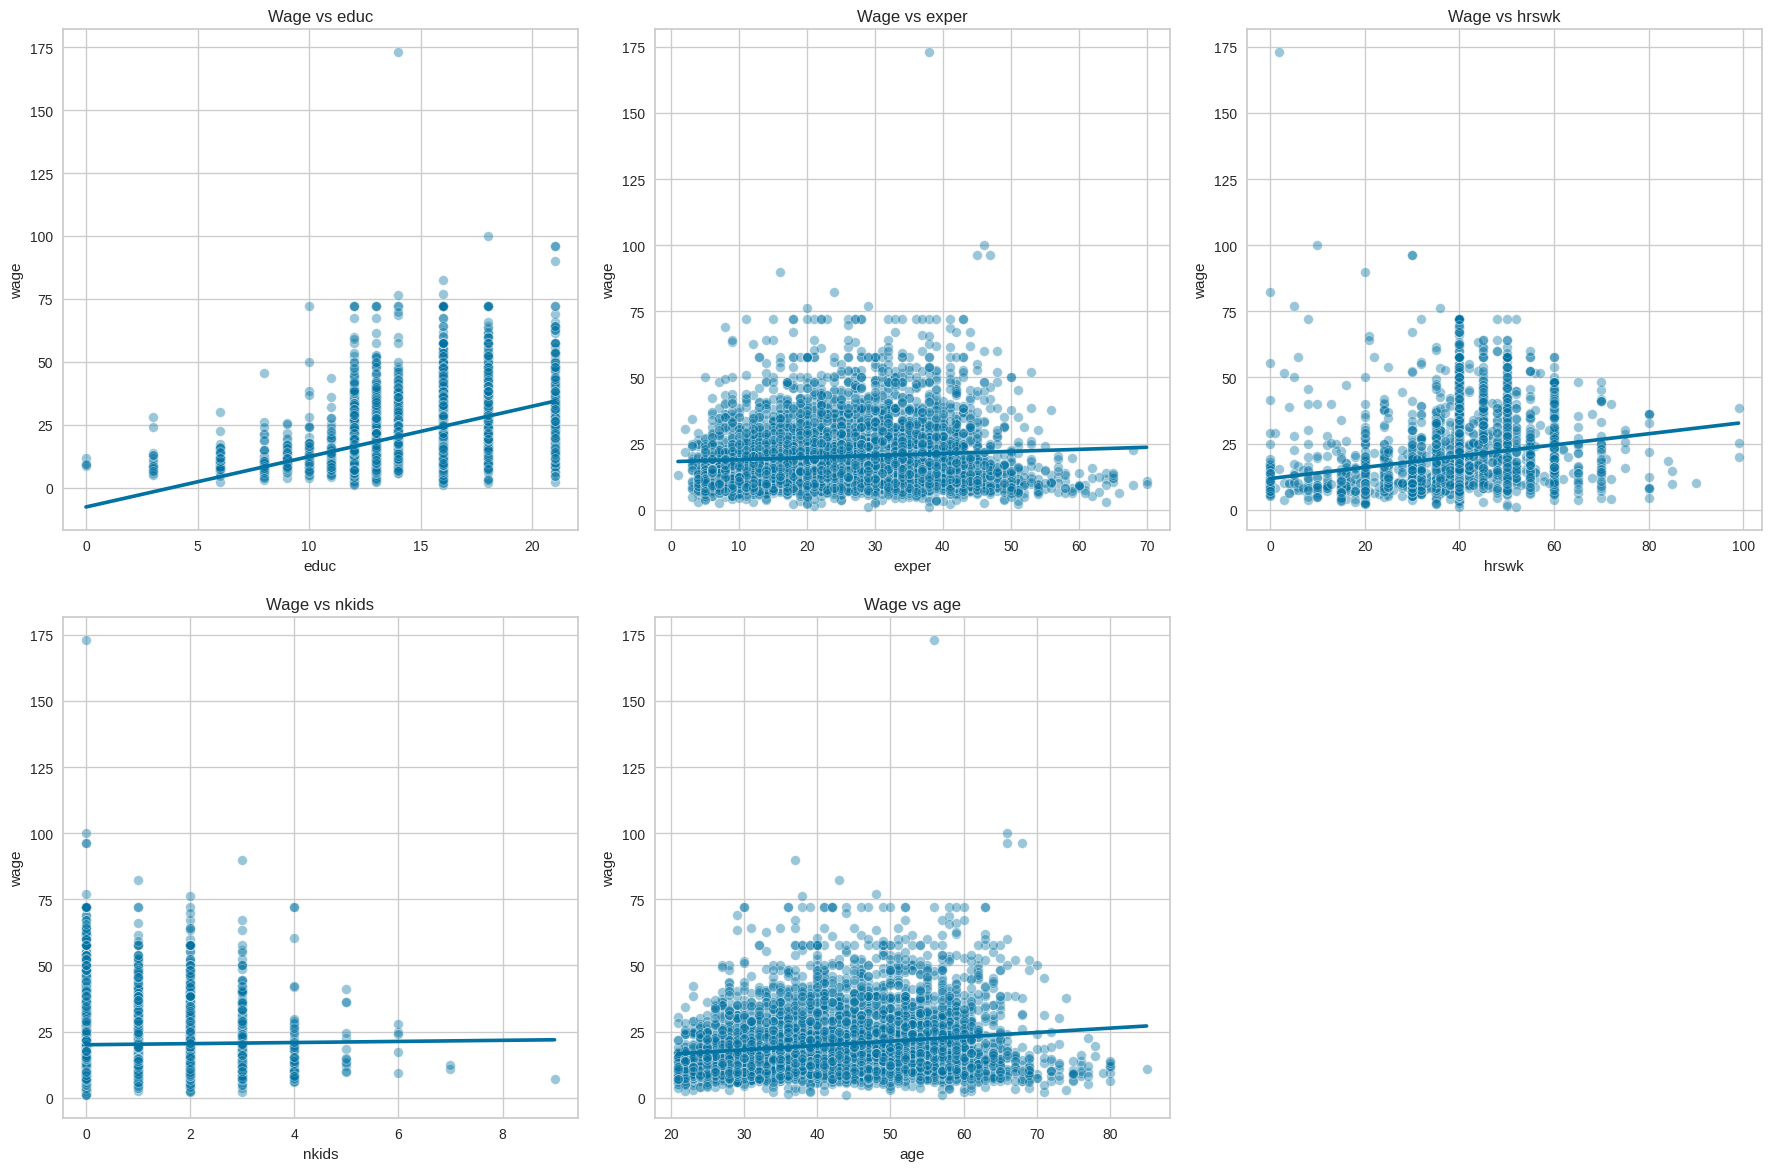

<Figure size 1500x1000 with 0 Axes>

<Axes: >

LinearRegression()

Text(0.5, 0, 'educ')

Text(0, 0.5, 'Residuos')

Text(0.5, 1.0, 'Heterocedasticidad: educ')

<Axes: >

LinearRegression()

Text(0.5, 0, 'exper')

Text(0, 0.5, 'Residuos')

Text(0.5, 1.0, 'Heterocedasticidad: exper')

<Axes: >

LinearRegression()

Text(0.5, 0, 'hrswk')

Text(0, 0.5, 'Residuos')

Text(0.5, 1.0, 'Heterocedasticidad: hrswk')

<Axes: >

LinearRegression()

Text(0.5, 0, 'nkids')

Text(0, 0.5, 'Residuos')

Text(0.5, 1.0, 'Heterocedasticidad: nkids')

<Axes: >

LinearRegression()

Text(0.5, 0, 'age')

Text(0, 0.5, 'Residuos')

Text(0.5, 1.0, 'Heterocedasticidad: age')

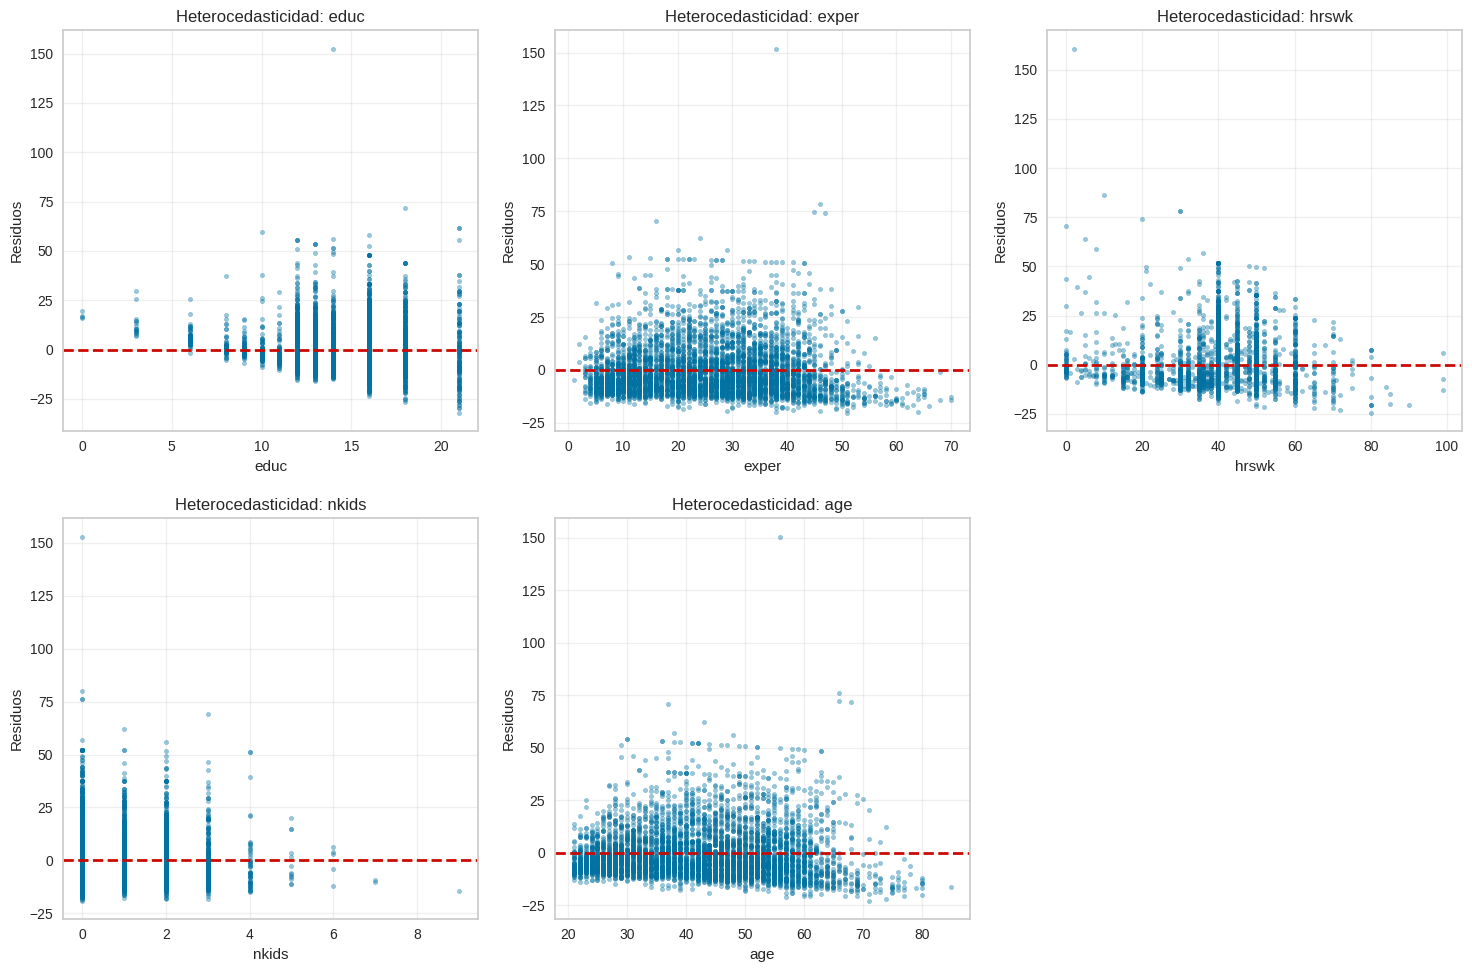

In [17]:
binary = ['fulltime', 'married', 'female', 'insurance', 'private', 'mcaid', 'mcare', 'metro', 'northeast', 'midwest', 'south', 'west', 'white', 'black', 'asian']
continuas = [col for col in X_train.columns if col not in binary]
print("Variables continuas: ")
print(continuas)

# Variables continuas vs wage
plt.figure(figsize = (18, 12))
for i, var in enumerate(continuas, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(data = wages, x = var, y = "wage", alpha = 0.4)
    sns.regplot(data = wages, x = var, y = "wage", scatter = False, ci = None)
    plt.title(f"Wage vs {var}")
plt.tight_layout()
plt.show()

# Analisis Heterocedasticidad
plt.figure(figsize = (15, 10))
for i, var in enumerate(continuas, 1):
    plt.subplot(2, 3, i)

    # Regresión simple
    X_simple = wages[[var]].values
    y = wages['wage'].values
    model_lr = LinearRegression()
    model_lr.fit(X_simple, y)
    y_pred_lr = model_lr.predict(X_simple)
    residuals = y - y_pred_lr

    # Gráfico de residuos vs variable
    plt.scatter(wages[var], residuals, alpha = 0.4, s = 10)
    plt.axhline(y = 0, color = 'r', linestyle = '--', linewidth = 2)

    plt.xlabel(var)
    plt.ylabel('Residuos')
    plt.title(f'Heterocedasticidad: {var}')
    plt.grid(True, alpha = 0.3)
plt.tight_layout()
plt.show()

Vemos en los primeros 5 gráficos ($wage$ vs variables) que $wage$ no tiene mucha correlación con las variables que no son discretas ni ordenadas (como ya habíamos visto con la matriz de correlaciones). Además, vemos que los valores de $wage$ en función de los valores de las variables siguen distribuciones distintas según la variable (excepto para $exper$ y $age$, que vemos una distribución similar debido a que hay una correlación muy alta entre estas dos variables como hemos visto antes en la matriz de correlaciones). Vamos a ver las variables que deberían tener mayor relación con el salario:
- $educ$: a priori, mayor educación debería significar mayor salario. Vemos que en efecto a mayor valor de esta variable aparecen valores más grandes de $wage$.
- $exper$: a priori, mayor experiencia debería significar mayor salario. Sin embargo, vemos que esto no es así. Además, de forma sorprendente vemos que a partir de los 55 años de experiencia solo hay sueldos bajos (menores que 25).
- $hrswk$: a priori, más horas semanales debería significar mayor salario. Sin embargo, vemos que esta relación tiene un límite; se cumple hasta las 40 horas semanales solo. A partir de 40 horas semanales el salario disminuye como podemos ver en el gráfico.

En los siguientes 5 gráficos comprobamos si efecto nos encontramos ante un problema con heterocedasticidad o no. Mirando a las variables $educ$, $hrswk$ i $nkids$ vemos que la nube de residuos se dispersa en función del valor de la variable (se dispersa al aumentar $educ$ y al disminuir las otras dos), lo que indica heterocedasticidad. Sin embargo, mirando a $exper$ y $age$ (correlacionadas entre sí) vemos que la varianza es bastante independiente del valor de la variable, indicando homocedasticidad. Vemos por tanto, que sí que nos encontramos ante un problema con heterocedasticidad ya que hay variables con heterocedasticidad. La presencia de heterocedasticidad en múltiples variables justifica el uso de modelos heterocedásticos ya que pueden capturar esta variabilidad y proporcionar estimaciones más precisas de la incertidumbre. La heterocedasticidad en solo algunas variables implica que factores como la educación y horas trabajadas introducen más ruido en las predicciones salariales que la experiencia o edad, lo cual tiene sentido en contextos laborales reales.

### Aplica un escalado min-max al conjunto de datos.

In [18]:
mmscaler = MinMaxScaler()

X_train_sc = mmscaler.fit_transform(X_train)
X_validation_sc = mmscaler.transform(X_validation)
X_test_sc = mmscaler.transform(X_test)

## b)
### Tenemos un problema de regresión, podemos usar un MLP que tenga una salida lineal para hacer la predicción con varias capas ocultas y ajustarlo usando mínimos cuadráticos (mean squared error). En el código del notebook tienes una función que permite generar modelos MLP variando el número de capas y la función de activación. Se le puede indicar que no se modela la varianza pasando False en el parámetro var. La red se define como una clase python donde en el método __init__ definimos los elementos de la red y en el forward como se hace la propagación hacia adelante en la red (la propagación hacia atrás se calcula automáticamente). Para pasarle los datos a un modelo de torch hay que definir una clase del tipo Dataset, tienes una definida en el notebook a la que hay que pasarle la matriz de datos y el vector con los valores reales que les corresponden. Esta clase se ha de pasar a un objeto Dataloader que se encarga de organizar el uso de los datos durante el entrenamiento, entre otras cosas de partir los datos en grupos (batch_size), podéis ver un ejemplo en el notebook. Para entrenar los modelos usaremos la función train_loop que tienes en el notebook. Esta función recibe el modelo, el optimizador a usar, los datos de entrenamiento y validación, la paciencia para la terminación temprana y el número de iteraciones que hará el entrenamiento. Para el optimizador usaremos adam, puedes ver en el notebook como generar el objeto del optimizador.

### Entrena diferentes redes de 1 y 2 capas ocultas con diferentes tamaños usando como función de activación nn.Sigmoid y nn.ReLU. Para los tamaños de las dos capas puedes elegir el tamaño de la primera capa oculta y después reducirlo a la mitad para la segunda capas. Para crear la red solo tienes que crear un objeto de la clase MLP pasándole los parámetros adecuados. Al generar el objeto tendras que subir el modelo a la GPU usando el método modelo.to(’cuda’) (si no torch se quejará de que los datos y el modelo no están en el mismo dispositivo). Verás que la función de entrenamiento retorna la historia de la función de pérdida para el entrenamiento y validación. Usa esta información para comprobar el número de épocas que realmente se realizan antes de parar. Puedes evaluar la sobre especialización de la red con el conjunto de test.

### Evalúa los resultados usando MAE y MSE. Para ello puedes usar la función test_model que tienes en el notebook. Se le ha de pasar el modelo entrenado y un conjunto de datos y retornará las predicciones y los valores reales, a partir de ahí puedes usar las funciones de scikit learn para obtener las medidas de evaluación.


Probando: hidden = [32], act = ReLU, lr = 0.001, batch = 32, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)


Probando: hidden = [32], act = ReLU, lr = 0.001, batch = 32, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)


Probando: hidden = [32], act = ReLU, lr = 0.001, batch = 64, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)


Probando: hidden = [32], act = ReLU, lr = 0.001, batch = 64, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)


Probando: hidden = [32], act = ReLU, lr = 0.001, batch = 128, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)


Probando: hidden = [32], act = ReLU, lr = 0.001, batch = 128, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)


Probando: hidden = [32], act = ReLU, lr = 0.0001, batch = 32, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)


Probando: hidden = [32], act = ReLU, lr = 0.0001, batch = 32, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)


Probando: hidden = [32], act = ReLU, lr = 0.0001, batch = 64, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)


Probando: hidden = [32], act = ReLU, lr = 0.0001, batch = 64, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)


Probando: hidden = [32], act = ReLU, lr = 0.0001, batch = 128, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)


Probando: hidden = [32], act = ReLU, lr = 0.0001, batch = 128, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)


Probando: hidden = [32], act = Sigmoid, lr = 0.001, batch = 32, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)


Probando: hidden = [32], act = Sigmoid, lr = 0.001, batch = 32, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)


Probando: hidden = [32], act = Sigmoid, lr = 0.001, batch = 64, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)


Probando: hidden = [32], act = Sigmoid, lr = 0.001, batch = 64, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)


Probando: hidden = [32], act = Sigmoid, lr = 0.001, batch = 128, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)


Probando: hidden = [32], act = Sigmoid, lr = 0.001, batch = 128, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)


Probando: hidden = [32], act = Sigmoid, lr = 0.0001, batch = 32, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)


Probando: hidden = [32], act = Sigmoid, lr = 0.0001, batch = 32, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)


Probando: hidden = [32], act = Sigmoid, lr = 0.0001, batch = 64, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)


Probando: hidden = [32], act = Sigmoid, lr = 0.0001, batch = 64, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)


Probando: hidden = [32], act = Sigmoid, lr = 0.0001, batch = 128, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)


Probando: hidden = [32], act = Sigmoid, lr = 0.0001, batch = 128, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)


Probando: hidden = [64], act = ReLU, lr = 0.001, batch = 32, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)


Probando: hidden = [64], act = ReLU, lr = 0.001, batch = 32, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)


Probando: hidden = [64], act = ReLU, lr = 0.001, batch = 64, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)


Probando: hidden = [64], act = ReLU, lr = 0.001, batch = 64, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)


Probando: hidden = [64], act = ReLU, lr = 0.001, batch = 128, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)


Probando: hidden = [64], act = ReLU, lr = 0.001, batch = 128, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)


Probando: hidden = [64], act = ReLU, lr = 0.0001, batch = 32, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)


Probando: hidden = [64], act = ReLU, lr = 0.0001, batch = 32, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)


Probando: hidden = [64], act = ReLU, lr = 0.0001, batch = 64, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)


Probando: hidden = [64], act = ReLU, lr = 0.0001, batch = 64, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)


Probando: hidden = [64], act = ReLU, lr = 0.0001, batch = 128, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)


Probando: hidden = [64], act = ReLU, lr = 0.0001, batch = 128, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)


Probando: hidden = [64], act = Sigmoid, lr = 0.001, batch = 32, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)


Probando: hidden = [64], act = Sigmoid, lr = 0.001, batch = 32, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)


Probando: hidden = [64], act = Sigmoid, lr = 0.001, batch = 64, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)


Probando: hidden = [64], act = Sigmoid, lr = 0.001, batch = 64, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)


Probando: hidden = [64], act = Sigmoid, lr = 0.001, batch = 128, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)


Probando: hidden = [64], act = Sigmoid, lr = 0.001, batch = 128, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)


Probando: hidden = [64], act = Sigmoid, lr = 0.0001, batch = 32, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)


Probando: hidden = [64], act = Sigmoid, lr = 0.0001, batch = 32, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)


Probando: hidden = [64], act = Sigmoid, lr = 0.0001, batch = 64, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)


Probando: hidden = [64], act = Sigmoid, lr = 0.0001, batch = 64, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)


Probando: hidden = [64], act = Sigmoid, lr = 0.0001, batch = 128, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)


Probando: hidden = [64], act = Sigmoid, lr = 0.0001, batch = 128, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)


Probando: hidden = [128], act = ReLU, lr = 0.001, batch = 32, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)


Probando: hidden = [128], act = ReLU, lr = 0.001, batch = 32, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)


Probando: hidden = [128], act = ReLU, lr = 0.001, batch = 64, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)


Probando: hidden = [128], act = ReLU, lr = 0.001, batch = 64, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)


Probando: hidden = [128], act = ReLU, lr = 0.001, batch = 128, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)


Probando: hidden = [128], act = ReLU, lr = 0.001, batch = 128, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)


Probando: hidden = [128], act = ReLU, lr = 0.0001, batch = 32, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)


Probando: hidden = [128], act = ReLU, lr = 0.0001, batch = 32, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)


Probando: hidden = [128], act = ReLU, lr = 0.0001, batch = 64, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)


Probando: hidden = [128], act = ReLU, lr = 0.0001, batch = 64, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)


Probando: hidden = [128], act = ReLU, lr = 0.0001, batch = 128, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)


Probando: hidden = [128], act = ReLU, lr = 0.0001, batch = 128, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)


Probando: hidden = [128], act = Sigmoid, lr = 0.001, batch = 32, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)


Probando: hidden = [128], act = Sigmoid, lr = 0.001, batch = 32, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)


Probando: hidden = [128], act = Sigmoid, lr = 0.001, batch = 64, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)


Probando: hidden = [128], act = Sigmoid, lr = 0.001, batch = 64, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)


Probando: hidden = [128], act = Sigmoid, lr = 0.001, batch = 128, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)


Probando: hidden = [128], act = Sigmoid, lr = 0.001, batch = 128, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)


Probando: hidden = [128], act = Sigmoid, lr = 0.0001, batch = 32, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)


Probando: hidden = [128], act = Sigmoid, lr = 0.0001, batch = 32, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)


Probando: hidden = [128], act = Sigmoid, lr = 0.0001, batch = 64, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)


Probando: hidden = [128], act = Sigmoid, lr = 0.0001, batch = 64, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)


Probando: hidden = [128], act = Sigmoid, lr = 0.0001, batch = 128, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)


Probando: hidden = [128], act = Sigmoid, lr = 0.0001, batch = 128, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)


Probando: hidden = [256], act = ReLU, lr = 0.001, batch = 32, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=256, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=256, out_features=1, bias=True)
)


Probando: hidden = [256], act = ReLU, lr = 0.001, batch = 32, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=256, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=256, out_features=1, bias=True)
)


Probando: hidden = [256], act = ReLU, lr = 0.001, batch = 64, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=256, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=256, out_features=1, bias=True)
)


Probando: hidden = [256], act = ReLU, lr = 0.001, batch = 64, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=256, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=256, out_features=1, bias=True)
)


Probando: hidden = [256], act = ReLU, lr = 0.001, batch = 128, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=256, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=256, out_features=1, bias=True)
)


Probando: hidden = [256], act = ReLU, lr = 0.001, batch = 128, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=256, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=256, out_features=1, bias=True)
)


Probando: hidden = [256], act = ReLU, lr = 0.0001, batch = 32, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=256, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=256, out_features=1, bias=True)
)


Probando: hidden = [256], act = ReLU, lr = 0.0001, batch = 32, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=256, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=256, out_features=1, bias=True)
)


Probando: hidden = [256], act = ReLU, lr = 0.0001, batch = 64, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=256, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=256, out_features=1, bias=True)
)


Probando: hidden = [256], act = ReLU, lr = 0.0001, batch = 64, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=256, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=256, out_features=1, bias=True)
)


Probando: hidden = [256], act = ReLU, lr = 0.0001, batch = 128, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=256, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=256, out_features=1, bias=True)
)


Probando: hidden = [256], act = ReLU, lr = 0.0001, batch = 128, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=256, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=256, out_features=1, bias=True)
)


Probando: hidden = [256], act = Sigmoid, lr = 0.001, batch = 32, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=256, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=256, out_features=1, bias=True)
)


Probando: hidden = [256], act = Sigmoid, lr = 0.001, batch = 32, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=256, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=256, out_features=1, bias=True)
)


Probando: hidden = [256], act = Sigmoid, lr = 0.001, batch = 64, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=256, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=256, out_features=1, bias=True)
)


Probando: hidden = [256], act = Sigmoid, lr = 0.001, batch = 64, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=256, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=256, out_features=1, bias=True)
)


Probando: hidden = [256], act = Sigmoid, lr = 0.001, batch = 128, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=256, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=256, out_features=1, bias=True)
)


Probando: hidden = [256], act = Sigmoid, lr = 0.001, batch = 128, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=256, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=256, out_features=1, bias=True)
)


Probando: hidden = [256], act = Sigmoid, lr = 0.0001, batch = 32, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=256, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=256, out_features=1, bias=True)
)


Probando: hidden = [256], act = Sigmoid, lr = 0.0001, batch = 32, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=256, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=256, out_features=1, bias=True)
)


Probando: hidden = [256], act = Sigmoid, lr = 0.0001, batch = 64, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=256, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=256, out_features=1, bias=True)
)


Probando: hidden = [256], act = Sigmoid, lr = 0.0001, batch = 64, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=256, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=256, out_features=1, bias=True)
)


Probando: hidden = [256], act = Sigmoid, lr = 0.0001, batch = 128, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=256, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=256, out_features=1, bias=True)
)


Probando: hidden = [256], act = Sigmoid, lr = 0.0001, batch = 128, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=256, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=256, out_features=1, bias=True)
)


Probando: hidden = [64, 32], act = ReLU, lr = 0.001, batch = 32, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)


Probando: hidden = [64, 32], act = ReLU, lr = 0.001, batch = 32, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)


Probando: hidden = [64, 32], act = ReLU, lr = 0.001, batch = 64, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)


Probando: hidden = [64, 32], act = ReLU, lr = 0.001, batch = 64, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)


Probando: hidden = [64, 32], act = ReLU, lr = 0.001, batch = 128, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)


Probando: hidden = [64, 32], act = ReLU, lr = 0.001, batch = 128, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)


Probando: hidden = [64, 32], act = ReLU, lr = 0.0001, batch = 32, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)


Probando: hidden = [64, 32], act = ReLU, lr = 0.0001, batch = 32, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)


Probando: hidden = [64, 32], act = ReLU, lr = 0.0001, batch = 64, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)


Probando: hidden = [64, 32], act = ReLU, lr = 0.0001, batch = 64, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)


Probando: hidden = [64, 32], act = ReLU, lr = 0.0001, batch = 128, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)


Probando: hidden = [64, 32], act = ReLU, lr = 0.0001, batch = 128, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)


Probando: hidden = [64, 32], act = Sigmoid, lr = 0.001, batch = 32, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)


Probando: hidden = [64, 32], act = Sigmoid, lr = 0.001, batch = 32, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)


Probando: hidden = [64, 32], act = Sigmoid, lr = 0.001, batch = 64, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)


Probando: hidden = [64, 32], act = Sigmoid, lr = 0.001, batch = 64, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)


Probando: hidden = [64, 32], act = Sigmoid, lr = 0.001, batch = 128, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)


Probando: hidden = [64, 32], act = Sigmoid, lr = 0.001, batch = 128, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)


Probando: hidden = [64, 32], act = Sigmoid, lr = 0.0001, batch = 32, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)


Probando: hidden = [64, 32], act = Sigmoid, lr = 0.0001, batch = 32, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)


Probando: hidden = [64, 32], act = Sigmoid, lr = 0.0001, batch = 64, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)


Probando: hidden = [64, 32], act = Sigmoid, lr = 0.0001, batch = 64, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)


Probando: hidden = [64, 32], act = Sigmoid, lr = 0.0001, batch = 128, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)


Probando: hidden = [64, 32], act = Sigmoid, lr = 0.0001, batch = 128, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)


Probando: hidden = [128, 64], act = ReLU, lr = 0.001, batch = 32, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)


Probando: hidden = [128, 64], act = ReLU, lr = 0.001, batch = 32, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)


Probando: hidden = [128, 64], act = ReLU, lr = 0.001, batch = 64, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)


Probando: hidden = [128, 64], act = ReLU, lr = 0.001, batch = 64, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)


Probando: hidden = [128, 64], act = ReLU, lr = 0.001, batch = 128, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)


Probando: hidden = [128, 64], act = ReLU, lr = 0.001, batch = 128, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)


Probando: hidden = [128, 64], act = ReLU, lr = 0.0001, batch = 32, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)


Probando: hidden = [128, 64], act = ReLU, lr = 0.0001, batch = 32, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)


Probando: hidden = [128, 64], act = ReLU, lr = 0.0001, batch = 64, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)


Probando: hidden = [128, 64], act = ReLU, lr = 0.0001, batch = 64, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)


Probando: hidden = [128, 64], act = ReLU, lr = 0.0001, batch = 128, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)


Probando: hidden = [128, 64], act = ReLU, lr = 0.0001, batch = 128, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)


Probando: hidden = [128, 64], act = Sigmoid, lr = 0.001, batch = 32, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)


Probando: hidden = [128, 64], act = Sigmoid, lr = 0.001, batch = 32, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)


Probando: hidden = [128, 64], act = Sigmoid, lr = 0.001, batch = 64, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)


Probando: hidden = [128, 64], act = Sigmoid, lr = 0.001, batch = 64, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)


Probando: hidden = [128, 64], act = Sigmoid, lr = 0.001, batch = 128, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)


Probando: hidden = [128, 64], act = Sigmoid, lr = 0.001, batch = 128, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)


Probando: hidden = [128, 64], act = Sigmoid, lr = 0.0001, batch = 32, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)


Probando: hidden = [128, 64], act = Sigmoid, lr = 0.0001, batch = 32, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)


Probando: hidden = [128, 64], act = Sigmoid, lr = 0.0001, batch = 64, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)


Probando: hidden = [128, 64], act = Sigmoid, lr = 0.0001, batch = 64, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)


Probando: hidden = [128, 64], act = Sigmoid, lr = 0.0001, batch = 128, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)


Probando: hidden = [128, 64], act = Sigmoid, lr = 0.0001, batch = 128, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)


Probando: hidden = [256, 128], act = ReLU, lr = 0.001, batch = 32, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)


Probando: hidden = [256, 128], act = ReLU, lr = 0.001, batch = 32, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)


Probando: hidden = [256, 128], act = ReLU, lr = 0.001, batch = 64, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)


Probando: hidden = [256, 128], act = ReLU, lr = 0.001, batch = 64, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)


Probando: hidden = [256, 128], act = ReLU, lr = 0.001, batch = 128, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)


Probando: hidden = [256, 128], act = ReLU, lr = 0.001, batch = 128, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)


Probando: hidden = [256, 128], act = ReLU, lr = 0.0001, batch = 32, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)


Probando: hidden = [256, 128], act = ReLU, lr = 0.0001, batch = 32, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)


Probando: hidden = [256, 128], act = ReLU, lr = 0.0001, batch = 64, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)


Probando: hidden = [256, 128], act = ReLU, lr = 0.0001, batch = 64, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)


Probando: hidden = [256, 128], act = ReLU, lr = 0.0001, batch = 128, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)


Probando: hidden = [256, 128], act = ReLU, lr = 0.0001, batch = 128, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)


Probando: hidden = [256, 128], act = Sigmoid, lr = 0.001, batch = 32, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)


Probando: hidden = [256, 128], act = Sigmoid, lr = 0.001, batch = 32, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)


Probando: hidden = [256, 128], act = Sigmoid, lr = 0.001, batch = 64, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)


Probando: hidden = [256, 128], act = Sigmoid, lr = 0.001, batch = 64, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)


Probando: hidden = [256, 128], act = Sigmoid, lr = 0.001, batch = 128, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)


Probando: hidden = [256, 128], act = Sigmoid, lr = 0.001, batch = 128, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)


Probando: hidden = [256, 128], act = Sigmoid, lr = 0.0001, batch = 32, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)


Probando: hidden = [256, 128], act = Sigmoid, lr = 0.0001, batch = 32, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)


Probando: hidden = [256, 128], act = Sigmoid, lr = 0.0001, batch = 64, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)


Probando: hidden = [256, 128], act = Sigmoid, lr = 0.0001, batch = 64, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)


Probando: hidden = [256, 128], act = Sigmoid, lr = 0.0001, batch = 128, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)


Probando: hidden = [256, 128], act = Sigmoid, lr = 0.0001, batch = 128, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)


MEJORES MODELOS HOMOCEDÁSTICOS:
Name: ReLU_[32]_0.0001_128_20 Layers' sizes: [32] Activation: ReLU LR: 0.0001 Batch size: 128 MAE: 8.221498489379883 MSE: 122.24717712402344
Name: ReLU_[32]_0.0001_128_10 Layers' sizes: [32] Activation: ReLU LR: 0.0001 Batch size: 128 MAE: 8.233745574951172 MSE: 122.50691223144531
Name: ReLU_[64]_0.0001_128_10 Layers' sizes: [64] Activation: ReLU LR: 0.0001 Batch size: 128 MAE: 8.309576988220215 MSE: 123.04046630859375
Name: ReLU_[64]_0.0001_128_20 Layers' sizes: [64] Activation: ReLU LR: 0.0001 Batch size: 128 MAE: 8.33873176574707 MSE: 123.45045471191406
Name: ReLU_[32]_0.0001_64_20 Layers' sizes: [32] Activation: ReLU LR: 0.0001 Batch size: 64 MAE: 8.345900535583496 MSE: 123.6534423828125

ANALISIS COMPLETO DEL MEJOR MODELO HOMOCEDÁSTICO:

MODELO SELECCIONADO: ReLU_[32]_0.0001_128_20
   - MAE en validación: 8.2215
   - MAE en test: 8.5781


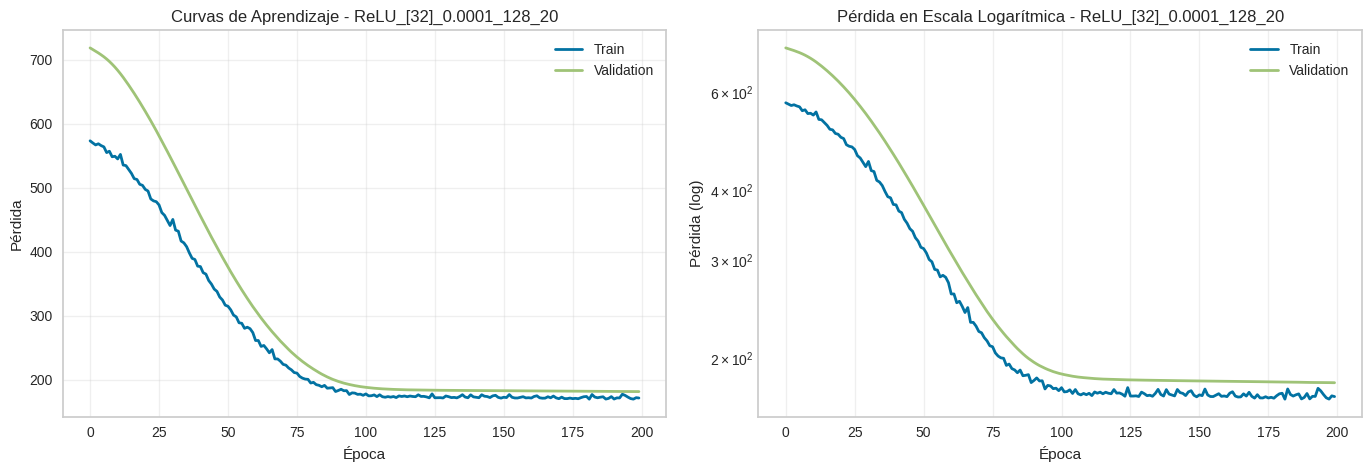


ANÁLISIS DE SOBRE-ESPECIALIZACIÓN - ReLU_[32]_0.0001_128_20
(comparación VALIDACIÓN vs TEST)
------------------------------------------------------------

MÉTRICAS DE RENDIMIENTO:
Métrica         Validación   Test         Diferencia   % Diferencia
--------------- ------------ ------------ ------------ ------------
MAE             8.2215       8.5781       0.3566       4.3         %
MSE             122.2472     140.6286     18.3814      15.0        %

DIAGNÓSTICO DE SOBRE-ESPECIALIZACIÓN:
✅ BUENA GENERALIZACIÓN: diferencia mínima (4.3%)
   El modelo generaliza bien a datos no vistos durante entrenamiento.


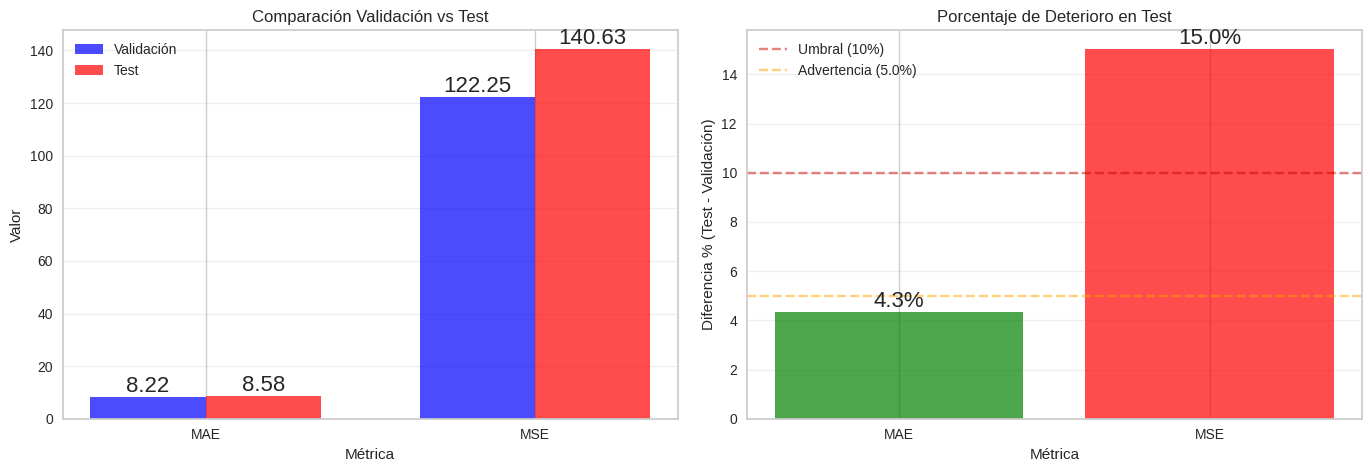

(4.3377080678437645, 15.036289296345757)

In [19]:
results = {}
maes = []

# Definir espacio de búsqueda
param_grid = {
    'hidden_sizes': [[32], [64], [128], [256], [64, 32], [128, 64], [256, 128]],
    'activations': [nn.ReLU, nn.Sigmoid],
    'lrs': [1e-3, 1e-4],
    'batch_sizes': [32, 64, 128],
    'patiences': [10, 20]
}

for hidden in param_grid['hidden_sizes']:
    for act in param_grid['activations']:
        for lr in param_grid['lrs']:
            for batch_size in param_grid['batch_sizes']:
                train_loader = torch.utils.data.DataLoader(wagesDataset(X_train_sc, Y_train.values), batch_size = batch_size, shuffle = True)
                val_loader = torch.utils.data.DataLoader(wagesDataset(X_validation_sc, Y_validation.values), batch_size = batch_size)
                test_loader = torch.utils.data.DataLoader(wagesDataset(X_test_sc, Y_test.values), batch_size = batch_size)
                for patience in param_grid['patiences']:
                    print(f"\nProbando: hidden = {hidden}, act = {act.__name__}, lr = {lr}, batch = {batch_size}, patience = {patience}")
                    modelname = f"{act.__name__}_{hidden}_{lr}_{batch_size}_{patience}"
                    model = MLPRegressor(input_size = X_train.shape[1], hidden_layers_sizes = hidden, activation = act, var = False).to("cuda")
                    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
                    hist_loss = train_loop(model = model, train = train_loader, val = val_loader, optimizer = optimizer, patience = patience, epochs = 200, lossf = F.mse_loss);

                    # Evaluar en validación para calidad del modelo
                    model.eval()
                    with torch.no_grad():
                      y_pred_val, y_true_val = test_model(model, val_loader)
                    # Calcular métricas
                    mae_val = mean_absolute_error(y_true_val, y_pred_val)
                    mse_val = mean_squared_error(y_true_val, y_pred_val)

                    # Evaluar en test para overfitting del modelo
                    model.eval()
                    with torch.no_grad():
                      y_pred_test, y_true_test = test_model(model, test_loader)
                    # Calcular métricas
                    mae_test = mean_absolute_error(y_true_test, y_pred_test)
                    mse_test = mean_squared_error(y_true_test, y_pred_test)

                    # Guardar resultados
                    results[modelname] = {
                      'hidden_sizes': str(hidden),
                      'activation': act.__name__,
                      'lr': lr,
                      'batch_size': batch_size,
                      'patience': patience,
                      'val_mae': mae_val,
                      'val_mse': mse_val,
                      'test_mae': mae_test,
                      'test_mse': mse_test,
                      'final_train_loss': hist_loss['train'][-1],
                      'final_val_loss': hist_loss['val'][-1],
                      'epochs_trained': len(hist_loss['train']),
                      'y_pred_val': y_pred_val,
                      'y_true_val': y_true_val,
                      'y_pred_test': y_pred_test,
                      'y_true_test': y_true_test,
                      'hist_loss': hist_loss
                    }
                    maes.append({'val_mae': mae_val, 'name': modelname})
df_results_homo = pd.DataFrame(maes)

print("\nMEJORES MODELOS HOMOCEDÁSTICOS:")
best_homo = df_results_homo.sort_values('val_mae').head(5)
for index, row in best_homo.iterrows():
    model_name = row['name']
    model_info = results[model_name]
    print(f"Name: {model_name} Layers' sizes: {model_info['hidden_sizes']} Activation: {model_info['activation']} LR: {model_info['lr']} Batch size: {model_info['batch_size']} MAE: {model_info['val_mae']} MSE: {model_info['val_mse']}")

print("\nANALISIS COMPLETO DEL MEJOR MODELO HOMOCEDÁSTICO:")
best_model_row = df_results_homo.sort_values('val_mae').iloc[0]
best_homo_name = best_model_row['name']
best_homo_info = results[best_homo_name]
print(f"\nMODELO SELECCIONADO: {best_homo_name}")
print(f"   - MAE en validación: {best_homo_info['val_mae']:.4f}")
print(f"   - MAE en test: {best_homo_info['test_mae']:.4f}")
plot_curvas_aprendizaje(best_homo_info['hist_loss'], best_homo_name)
analyze_overfitting(best_homo_info, best_homo_name, 10)

Se ha realizado una búsqueda exhaustiva de hiperparámetros abarcando un espacio considerablemente amplio; evaluando múltiples combinaciones de arquitecturas (modelos de 1 y 2 capas), funciones de activación, tasas de aprendizaje (lr), tamaños de batch y valores de paciencia para el early stopping.

Los resultados indican que los mejores modelos homocedásticos obtenidos no alcanzan un rendimiento óptimo, con un Error Absoluto Medio (MAE) en el rango de 8.2 a 8.3 unidades. Este valor debe interpretarse en el contexto de los datos del dataset: aunque el rango salarial completo del conjunto de datos es de aproximadamente 75 unidades, la gran mayoría de las observaciones se concentra en un intervalo de 40 unidades. Por lo tanto, un MAE de más de 8 unidades representa un error relativamente alto, lo que sugiere un margen significativo de mejora en la capacidad predictiva del modelo.

El análisis de los 5 mejores modelos, seleccionados según el MAE en el conjunto de validación, revela patrones claros en la configuración óptima:
- Arquitectura: Todos poseen una sola capa oculta, con tamaños de 32, 32, 64, 64 y 32 neuronas, respectivamente.
- Función de activación: ReLU es elegida sistemáticamente.
- Tasa de aprendizaje (learning rate): El valor óptimo es consistentemente 1e-4.
- Tamaño de lote (batch size): 128 es el preferido, usado por los cuatro mejores modelos; el quinto emplea 64.
- Métricas: Los modelos presentan valores muy similares de MAE (8.2-8.3) y MSE (122-123).

Que siempre se use 1 sola capa indica que los patrones no lineales presentes en los datos son posiblemente lo suficientemente simples como para ser capturados por una sola transformación no lineal; arquitecturas más profundas (2 capas) probablemente causan sobreajuste o no aportan suficiente mejora para justificar su complejidad adicional.

ReLU se prefiere frente a funciones como la sigmoide porque evita el problema de la saturación y el consecuente desvanecimiento del gradiente, manteniendo valores de gradiente útiles para entrenar la red incluso cuando las activaciones son grandes. Esto permite un aprendizaje más rápido, estable y eficiente tanto en redes profundas como en redes poco profundas.

Las curvas de aprendizaje muestran que la pérdida se estabiliza aproximadamente a partir de la época 100, indicando una convergencia adecuada del algoritmo de optimización. La diferencia de rendimiento entre los conjuntos de validación y prueba es del 4.3% para el MAE y del 15% para el MSE, lo que sugiere una capacidad de generalización aceptable sin un sobreajuste excesivo. Vemos además que ambas curvas (train y validation) son notablemente similares, con la curva de validación situándose ligeramente por encima y convergiendo con la curva de train al final del entrenamiento. Este comportamiento confirma la ausencia de un sobreajuste significativo y la estabilidad del proceso de aprendizaje.

Cabe destacar que la mayoría de modelos finalizó antes de las 200 épocas gracias al mecanismo de early stopping, lo que demuestra la utilidad de este criterio para evitar iteraciones innecesarias y optimizar el tiempo de cómputo.

En conjunto, los resultados del modelo homocedástico establecen un punto de referencia: el rendimiento obtenido representa el mejor resultado que puede lograrse suponiendo una varianza constante en los errores (homocedasticidad). Esto proporciona el contexto necesario para evaluar, en el siguiente apartado, si modelar explícitamente la heterocedasticidad ofrece ventajas predictivas significativas, tal como sugerían los análisis exploratorios iniciales.

## c)
### El ajuste por error cuadrático, como vimos en el tema de regresión lineal, asume que el ruido es gausiano y su varianza es la misma para todas las predicciones, por lo que solo es necesario aprender una función que prediga su media. El modelo que tienes en el notebook permite indicar que se quiere predecir también la varianza de los datos. En este caso tenemos dos salidas, una para la media y otra para la varianza. Fijate que ahora la función de perdida no ha de ser el error cuadrático sino la función RegressionLoss. Esta función recibe las dos salidas de la red. Explica qué está prediciendo exactamente la red (qué valores de salida se calculan) y la función de pérdida, y como encajan con el cálculo de la log verosimilitud negativa de la gausiana cuando la varianza no es fija. En otras palabras, mírate cuál es la fórmula de la log verosimilitud de la gausiana en este caso e identifica los cálculos en la función RegressionLoss.

- Primera salida: la media de la distribución normal para ese punto.
- Segunda salida: el logaritmo de la varianza.

La red no predice σ directamente, sino log σ² por estabilidad numérica y para asegurar que σ² > 0.
La función de pérdida está implementando la log-verosimilitud negativa de una normal:
- Loss = (y - 𝜇)²/𝜎² + log(𝜎²)

Sin el factor 1/2 porque es una constante y no afecta al gradiente, y sin la constante log(2𝜋).
La red esta aprendiendo dos medidas:
- la media **μ**, que ajusta el valor central
- la varianza **σ²**, que captura la heterocedasticidad intrínseca de los datos
La loss function penaliza errores grandes cuando σ² es pequeña y varianzas grandes innecesarias (por el término log σ²). Es decir, la red aprende "cuándo está segura" y cuándo no.

RegressionLoss implementa la log-verosimilitud negativa de una distribución normal con varianza dependiente de x, lo cual permite regresión heteroscedástica (incertidumbre dependiente de los datos).

### Ajusta las mismas redes que has usado en el apartado anterior y selecciona la que dé el mejor resultado.


Probando: hidden = [32], act = ReLU, lr = 0.001, batch = 32, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)


Probando: hidden = [32], act = ReLU, lr = 0.001, batch = 32, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)


Probando: hidden = [32], act = ReLU, lr = 0.001, batch = 64, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)


Probando: hidden = [32], act = ReLU, lr = 0.001, batch = 64, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)


Probando: hidden = [32], act = ReLU, lr = 0.001, batch = 128, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)


Probando: hidden = [32], act = ReLU, lr = 0.001, batch = 128, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)


Probando: hidden = [32], act = ReLU, lr = 0.0001, batch = 32, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)


Probando: hidden = [32], act = ReLU, lr = 0.0001, batch = 32, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)


Probando: hidden = [32], act = ReLU, lr = 0.0001, batch = 64, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)


Probando: hidden = [32], act = ReLU, lr = 0.0001, batch = 64, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)


Probando: hidden = [32], act = ReLU, lr = 0.0001, batch = 128, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)


Probando: hidden = [32], act = ReLU, lr = 0.0001, batch = 128, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)


Probando: hidden = [32], act = Sigmoid, lr = 0.001, batch = 32, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)


Probando: hidden = [32], act = Sigmoid, lr = 0.001, batch = 32, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)


Probando: hidden = [32], act = Sigmoid, lr = 0.001, batch = 64, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)


Probando: hidden = [32], act = Sigmoid, lr = 0.001, batch = 64, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)


Probando: hidden = [32], act = Sigmoid, lr = 0.001, batch = 128, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)


Probando: hidden = [32], act = Sigmoid, lr = 0.001, batch = 128, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)


Probando: hidden = [32], act = Sigmoid, lr = 0.0001, batch = 32, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)


Probando: hidden = [32], act = Sigmoid, lr = 0.0001, batch = 32, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)


Probando: hidden = [32], act = Sigmoid, lr = 0.0001, batch = 64, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)


Probando: hidden = [32], act = Sigmoid, lr = 0.0001, batch = 64, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)


Probando: hidden = [32], act = Sigmoid, lr = 0.0001, batch = 128, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)


Probando: hidden = [32], act = Sigmoid, lr = 0.0001, batch = 128, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)


Probando: hidden = [64], act = ReLU, lr = 0.001, batch = 32, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)


Probando: hidden = [64], act = ReLU, lr = 0.001, batch = 32, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)


Probando: hidden = [64], act = ReLU, lr = 0.001, batch = 64, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)


Probando: hidden = [64], act = ReLU, lr = 0.001, batch = 64, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)


Probando: hidden = [64], act = ReLU, lr = 0.001, batch = 128, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)


Probando: hidden = [64], act = ReLU, lr = 0.001, batch = 128, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)


Probando: hidden = [64], act = ReLU, lr = 0.0001, batch = 32, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)


Probando: hidden = [64], act = ReLU, lr = 0.0001, batch = 32, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)


Probando: hidden = [64], act = ReLU, lr = 0.0001, batch = 64, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)


Probando: hidden = [64], act = ReLU, lr = 0.0001, batch = 64, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)


Probando: hidden = [64], act = ReLU, lr = 0.0001, batch = 128, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)


Probando: hidden = [64], act = ReLU, lr = 0.0001, batch = 128, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)


Probando: hidden = [64], act = Sigmoid, lr = 0.001, batch = 32, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)


Probando: hidden = [64], act = Sigmoid, lr = 0.001, batch = 32, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)


Probando: hidden = [64], act = Sigmoid, lr = 0.001, batch = 64, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)


Probando: hidden = [64], act = Sigmoid, lr = 0.001, batch = 64, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)


Probando: hidden = [64], act = Sigmoid, lr = 0.001, batch = 128, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)


Probando: hidden = [64], act = Sigmoid, lr = 0.001, batch = 128, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)


Probando: hidden = [64], act = Sigmoid, lr = 0.0001, batch = 32, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)


Probando: hidden = [64], act = Sigmoid, lr = 0.0001, batch = 32, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)


Probando: hidden = [64], act = Sigmoid, lr = 0.0001, batch = 64, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)


Probando: hidden = [64], act = Sigmoid, lr = 0.0001, batch = 64, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)


Probando: hidden = [64], act = Sigmoid, lr = 0.0001, batch = 128, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)


Probando: hidden = [64], act = Sigmoid, lr = 0.0001, batch = 128, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)


Probando: hidden = [128], act = ReLU, lr = 0.001, batch = 32, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)


Probando: hidden = [128], act = ReLU, lr = 0.001, batch = 32, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)


Probando: hidden = [128], act = ReLU, lr = 0.001, batch = 64, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)


Probando: hidden = [128], act = ReLU, lr = 0.001, batch = 64, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)


Probando: hidden = [128], act = ReLU, lr = 0.001, batch = 128, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)


Probando: hidden = [128], act = ReLU, lr = 0.001, batch = 128, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)


Probando: hidden = [128], act = ReLU, lr = 0.0001, batch = 32, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)


Probando: hidden = [128], act = ReLU, lr = 0.0001, batch = 32, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)


Probando: hidden = [128], act = ReLU, lr = 0.0001, batch = 64, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)


Probando: hidden = [128], act = ReLU, lr = 0.0001, batch = 64, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)


Probando: hidden = [128], act = ReLU, lr = 0.0001, batch = 128, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)


Probando: hidden = [128], act = ReLU, lr = 0.0001, batch = 128, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)


Probando: hidden = [128], act = Sigmoid, lr = 0.001, batch = 32, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)


Probando: hidden = [128], act = Sigmoid, lr = 0.001, batch = 32, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)


Probando: hidden = [128], act = Sigmoid, lr = 0.001, batch = 64, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)


Probando: hidden = [128], act = Sigmoid, lr = 0.001, batch = 64, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)


Probando: hidden = [128], act = Sigmoid, lr = 0.001, batch = 128, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)


Probando: hidden = [128], act = Sigmoid, lr = 0.001, batch = 128, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)


Probando: hidden = [128], act = Sigmoid, lr = 0.0001, batch = 32, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)


Probando: hidden = [128], act = Sigmoid, lr = 0.0001, batch = 32, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)


Probando: hidden = [128], act = Sigmoid, lr = 0.0001, batch = 64, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)


Probando: hidden = [128], act = Sigmoid, lr = 0.0001, batch = 64, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)


Probando: hidden = [128], act = Sigmoid, lr = 0.0001, batch = 128, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)


Probando: hidden = [128], act = Sigmoid, lr = 0.0001, batch = 128, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)


Probando: hidden = [256], act = ReLU, lr = 0.001, batch = 32, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=256, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=256, out_features=2, bias=True)
)


Probando: hidden = [256], act = ReLU, lr = 0.001, batch = 32, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=256, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=256, out_features=2, bias=True)
)


Probando: hidden = [256], act = ReLU, lr = 0.001, batch = 64, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=256, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=256, out_features=2, bias=True)
)


Probando: hidden = [256], act = ReLU, lr = 0.001, batch = 64, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=256, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=256, out_features=2, bias=True)
)


Probando: hidden = [256], act = ReLU, lr = 0.001, batch = 128, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=256, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=256, out_features=2, bias=True)
)


Probando: hidden = [256], act = ReLU, lr = 0.001, batch = 128, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=256, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=256, out_features=2, bias=True)
)


Probando: hidden = [256], act = ReLU, lr = 0.0001, batch = 32, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=256, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=256, out_features=2, bias=True)
)


Probando: hidden = [256], act = ReLU, lr = 0.0001, batch = 32, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=256, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=256, out_features=2, bias=True)
)


Probando: hidden = [256], act = ReLU, lr = 0.0001, batch = 64, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=256, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=256, out_features=2, bias=True)
)


Probando: hidden = [256], act = ReLU, lr = 0.0001, batch = 64, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=256, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=256, out_features=2, bias=True)
)


Probando: hidden = [256], act = ReLU, lr = 0.0001, batch = 128, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=256, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=256, out_features=2, bias=True)
)


Probando: hidden = [256], act = ReLU, lr = 0.0001, batch = 128, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=256, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=256, out_features=2, bias=True)
)


Probando: hidden = [256], act = Sigmoid, lr = 0.001, batch = 32, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=256, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=256, out_features=2, bias=True)
)


Probando: hidden = [256], act = Sigmoid, lr = 0.001, batch = 32, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=256, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=256, out_features=2, bias=True)
)


Probando: hidden = [256], act = Sigmoid, lr = 0.001, batch = 64, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=256, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=256, out_features=2, bias=True)
)


Probando: hidden = [256], act = Sigmoid, lr = 0.001, batch = 64, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=256, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=256, out_features=2, bias=True)
)


Probando: hidden = [256], act = Sigmoid, lr = 0.001, batch = 128, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=256, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=256, out_features=2, bias=True)
)


Probando: hidden = [256], act = Sigmoid, lr = 0.001, batch = 128, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=256, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=256, out_features=2, bias=True)
)


Probando: hidden = [256], act = Sigmoid, lr = 0.0001, batch = 32, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=256, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=256, out_features=2, bias=True)
)


Probando: hidden = [256], act = Sigmoid, lr = 0.0001, batch = 32, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=256, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=256, out_features=2, bias=True)
)


Probando: hidden = [256], act = Sigmoid, lr = 0.0001, batch = 64, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=256, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=256, out_features=2, bias=True)
)


Probando: hidden = [256], act = Sigmoid, lr = 0.0001, batch = 64, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=256, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=256, out_features=2, bias=True)
)


Probando: hidden = [256], act = Sigmoid, lr = 0.0001, batch = 128, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=256, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=256, out_features=2, bias=True)
)


Probando: hidden = [256], act = Sigmoid, lr = 0.0001, batch = 128, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=256, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=256, out_features=2, bias=True)
)


Probando: hidden = [64, 32], act = ReLU, lr = 0.001, batch = 32, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)


Probando: hidden = [64, 32], act = ReLU, lr = 0.001, batch = 32, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)


Probando: hidden = [64, 32], act = ReLU, lr = 0.001, batch = 64, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)


Probando: hidden = [64, 32], act = ReLU, lr = 0.001, batch = 64, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)


Probando: hidden = [64, 32], act = ReLU, lr = 0.001, batch = 128, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)


Probando: hidden = [64, 32], act = ReLU, lr = 0.001, batch = 128, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)


Probando: hidden = [64, 32], act = ReLU, lr = 0.0001, batch = 32, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)


Probando: hidden = [64, 32], act = ReLU, lr = 0.0001, batch = 32, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)


Probando: hidden = [64, 32], act = ReLU, lr = 0.0001, batch = 64, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)


Probando: hidden = [64, 32], act = ReLU, lr = 0.0001, batch = 64, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)


Probando: hidden = [64, 32], act = ReLU, lr = 0.0001, batch = 128, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)


Probando: hidden = [64, 32], act = ReLU, lr = 0.0001, batch = 128, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)


Probando: hidden = [64, 32], act = Sigmoid, lr = 0.001, batch = 32, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)


Probando: hidden = [64, 32], act = Sigmoid, lr = 0.001, batch = 32, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)


Probando: hidden = [64, 32], act = Sigmoid, lr = 0.001, batch = 64, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)


Probando: hidden = [64, 32], act = Sigmoid, lr = 0.001, batch = 64, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)


Probando: hidden = [64, 32], act = Sigmoid, lr = 0.001, batch = 128, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)


Probando: hidden = [64, 32], act = Sigmoid, lr = 0.001, batch = 128, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)


Probando: hidden = [64, 32], act = Sigmoid, lr = 0.0001, batch = 32, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)


Probando: hidden = [64, 32], act = Sigmoid, lr = 0.0001, batch = 32, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)


Probando: hidden = [64, 32], act = Sigmoid, lr = 0.0001, batch = 64, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)


Probando: hidden = [64, 32], act = Sigmoid, lr = 0.0001, batch = 64, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)


Probando: hidden = [64, 32], act = Sigmoid, lr = 0.0001, batch = 128, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)


Probando: hidden = [64, 32], act = Sigmoid, lr = 0.0001, batch = 128, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)


Probando: hidden = [128, 64], act = ReLU, lr = 0.001, batch = 32, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)


Probando: hidden = [128, 64], act = ReLU, lr = 0.001, batch = 32, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)


Probando: hidden = [128, 64], act = ReLU, lr = 0.001, batch = 64, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)


Probando: hidden = [128, 64], act = ReLU, lr = 0.001, batch = 64, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)


Probando: hidden = [128, 64], act = ReLU, lr = 0.001, batch = 128, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)


Probando: hidden = [128, 64], act = ReLU, lr = 0.001, batch = 128, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)


Probando: hidden = [128, 64], act = ReLU, lr = 0.0001, batch = 32, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)


Probando: hidden = [128, 64], act = ReLU, lr = 0.0001, batch = 32, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)


Probando: hidden = [128, 64], act = ReLU, lr = 0.0001, batch = 64, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)


Probando: hidden = [128, 64], act = ReLU, lr = 0.0001, batch = 64, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)


Probando: hidden = [128, 64], act = ReLU, lr = 0.0001, batch = 128, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)


Probando: hidden = [128, 64], act = ReLU, lr = 0.0001, batch = 128, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)


Probando: hidden = [128, 64], act = Sigmoid, lr = 0.001, batch = 32, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)


Probando: hidden = [128, 64], act = Sigmoid, lr = 0.001, batch = 32, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)


Probando: hidden = [128, 64], act = Sigmoid, lr = 0.001, batch = 64, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)


Probando: hidden = [128, 64], act = Sigmoid, lr = 0.001, batch = 64, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)


Probando: hidden = [128, 64], act = Sigmoid, lr = 0.001, batch = 128, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)


Probando: hidden = [128, 64], act = Sigmoid, lr = 0.001, batch = 128, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)


Probando: hidden = [128, 64], act = Sigmoid, lr = 0.0001, batch = 32, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)


Probando: hidden = [128, 64], act = Sigmoid, lr = 0.0001, batch = 32, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)


Probando: hidden = [128, 64], act = Sigmoid, lr = 0.0001, batch = 64, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)


Probando: hidden = [128, 64], act = Sigmoid, lr = 0.0001, batch = 64, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)


Probando: hidden = [128, 64], act = Sigmoid, lr = 0.0001, batch = 128, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)


Probando: hidden = [128, 64], act = Sigmoid, lr = 0.0001, batch = 128, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)


Probando: hidden = [256, 128], act = ReLU, lr = 0.001, batch = 32, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)


Probando: hidden = [256, 128], act = ReLU, lr = 0.001, batch = 32, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)


Probando: hidden = [256, 128], act = ReLU, lr = 0.001, batch = 64, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)


Probando: hidden = [256, 128], act = ReLU, lr = 0.001, batch = 64, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)


Probando: hidden = [256, 128], act = ReLU, lr = 0.001, batch = 128, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)


Probando: hidden = [256, 128], act = ReLU, lr = 0.001, batch = 128, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)


Probando: hidden = [256, 128], act = ReLU, lr = 0.0001, batch = 32, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)


Probando: hidden = [256, 128], act = ReLU, lr = 0.0001, batch = 32, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)


Probando: hidden = [256, 128], act = ReLU, lr = 0.0001, batch = 64, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)


Probando: hidden = [256, 128], act = ReLU, lr = 0.0001, batch = 64, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)


Probando: hidden = [256, 128], act = ReLU, lr = 0.0001, batch = 128, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)


Probando: hidden = [256, 128], act = ReLU, lr = 0.0001, batch = 128, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)


Probando: hidden = [256, 128], act = Sigmoid, lr = 0.001, batch = 32, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)


Probando: hidden = [256, 128], act = Sigmoid, lr = 0.001, batch = 32, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)


Probando: hidden = [256, 128], act = Sigmoid, lr = 0.001, batch = 64, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)


Probando: hidden = [256, 128], act = Sigmoid, lr = 0.001, batch = 64, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)


Probando: hidden = [256, 128], act = Sigmoid, lr = 0.001, batch = 128, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)


Probando: hidden = [256, 128], act = Sigmoid, lr = 0.001, batch = 128, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)


Probando: hidden = [256, 128], act = Sigmoid, lr = 0.0001, batch = 32, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)


Probando: hidden = [256, 128], act = Sigmoid, lr = 0.0001, batch = 32, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)


Probando: hidden = [256, 128], act = Sigmoid, lr = 0.0001, batch = 64, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)


Probando: hidden = [256, 128], act = Sigmoid, lr = 0.0001, batch = 64, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)


Probando: hidden = [256, 128], act = Sigmoid, lr = 0.0001, batch = 128, patience = 10


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)


Probando: hidden = [256, 128], act = Sigmoid, lr = 0.0001, batch = 128, patience = 20


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)

MLPRegressor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)


MEJORES MODELOS HETEROCEDÁSTICOS:
Name: <class 'torch.nn.modules.activation.ReLU'>_[256, 128]_0.001_64_20 Layers' sizes: [256, 128] Activation: ReLU LR: 0.001 Batch size: 64 MAE: 6.754392623901367 MSE: 95.31819915771484
Name: <class 'torch.nn.modules.activation.Sigmoid'>_[256, 128]_0.001_32_20 Layers' sizes: [256, 128] Activation: Sigmoid LR: 0.001 Batch size: 32 MAE: 6.776682376861572 MSE: 97.44490051269531
Name: <class 'torch.nn.modules.activation.ReLU'>_[256, 128]_0.001_32_10 Layers' sizes: [256, 128] Activation: ReLU LR: 0.001 Batch size: 32 MAE: 6.814182281494141 MSE: 96.9230728149414
Name: <class 'torch.nn.modules.activation.ReLU'>_[256, 128]_0.001_128_20 Layers' sizes: [256, 128] Activation: ReLU LR: 0.001 Batch size: 128 MAE: 6.830984115600586 MSE: 97.79947662353516
Name: <class 'torch.nn.modules.activation.ReLU'>_[256, 128]_0.001_32_20 Layers' sizes: [256, 128] Activation: ReLU LR: 0.001 Batch size: 32 MAE: 6.86264181137085 MSE: 100.97382354736328

ANALISIS COMPLETO DEL MEJOR

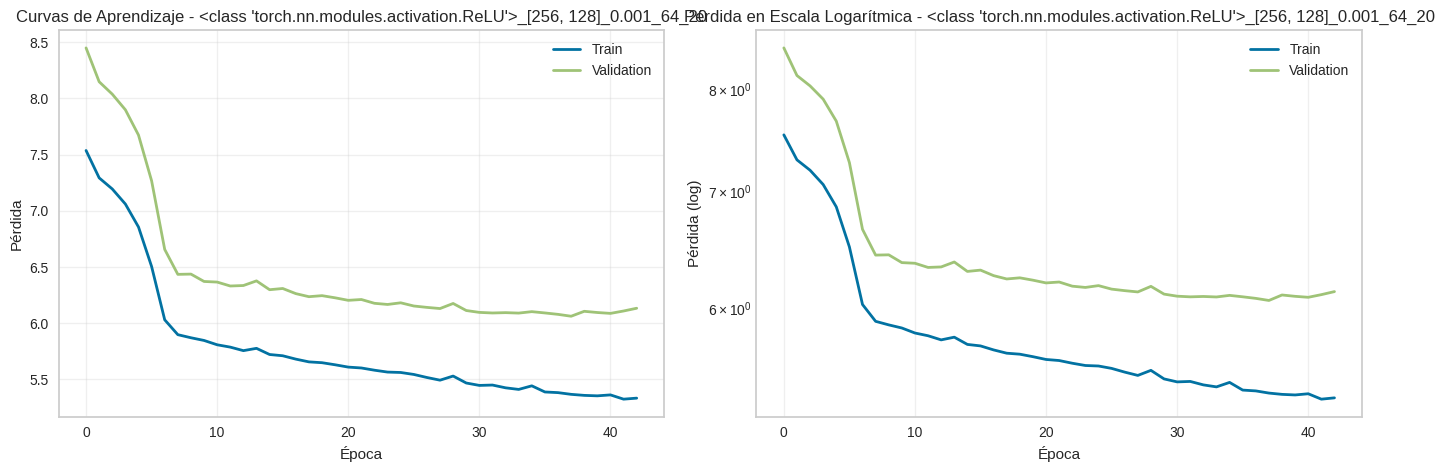


ANÁLISIS DE SOBRE-ESPECIALIZACIÓN - <class 'torch.nn.modules.activation.ReLU'>_[256, 128]_0.001_64_20
(comparación VALIDACIÓN vs TEST)
------------------------------------------------------------

MÉTRICAS DE RENDIMIENTO:
Métrica         Validación   Test         Diferencia   % Diferencia
--------------- ------------ ------------ ------------ ------------
MAE             6.7544       7.0664       0.3120       4.6         %
MSE             95.3182      108.2630     12.9448      13.6        %

DIAGNÓSTICO DE SOBRE-ESPECIALIZACIÓN:
✅ BUENA GENERALIZACIÓN: diferencia mínima (4.6%)
   El modelo generaliza bien a datos no vistos durante entrenamiento.


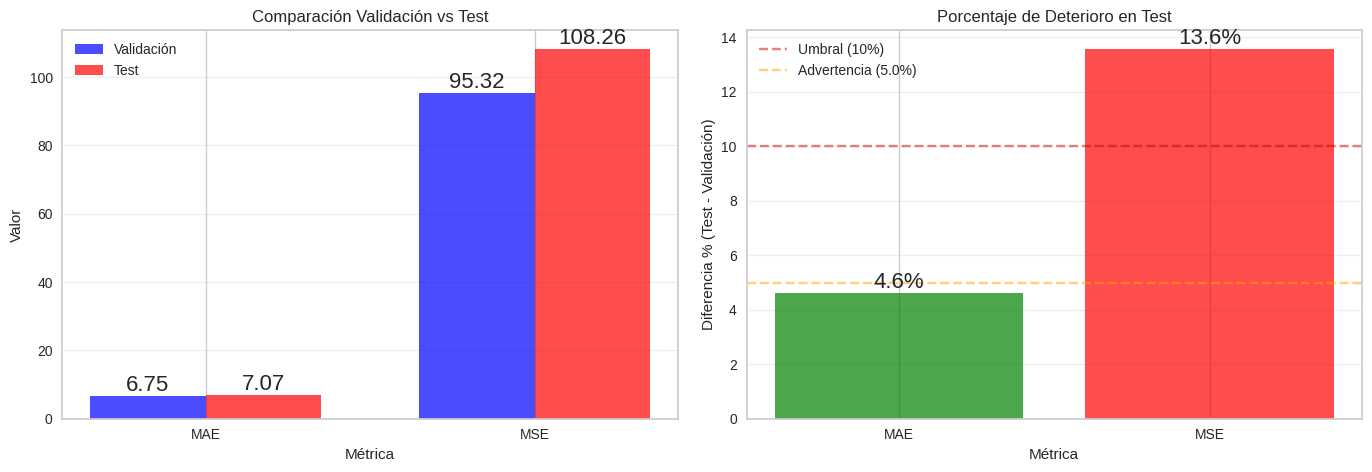

(4.618987322827241, 13.580642871075765)

In [30]:
results = {}
maes = []

# Definir espacio de búsqueda
param_grid = {
    'hidden_sizes': [[32], [64], [128], [256], [64, 32], [128, 64], [256, 128]],
    'activations': [nn.ReLU, nn.Sigmoid],
    'lrs': [1e-3, 1e-4],
    'batch_sizes': [32, 64, 128],
    'patiences': [10, 20]
}

for hidden in param_grid['hidden_sizes']:
    for act in param_grid['activations']:
        for lr in param_grid['lrs']:
            for batch_size in param_grid['batch_sizes']:
                train_loader = torch.utils.data.DataLoader(wagesDataset(X_train_sc, Y_train.values), batch_size = batch_size, shuffle = True)
                val_loader = torch.utils.data.DataLoader(wagesDataset(X_validation_sc, Y_validation.values), batch_size = batch_size)
                test_loader = torch.utils.data.DataLoader(wagesDataset(X_test_sc, Y_test.values), batch_size = batch_size)
                for patience in param_grid['patiences']:
                    print(f"\nProbando: hidden = {hidden}, act = {act.__name__}, lr = {lr}, batch = {batch_size}, patience = {patience}")
                    modelname = f"{act}_{hidden}_{lr}_{batch_size}_{patience}"
                    model = MLPRegressor(input_size = X_train.shape[1], hidden_layers_sizes = hidden, activation = act, var = True).to("cuda")
                    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
                    hist_loss = train_loop(model = model, train = train_loader, val = val_loader, optimizer = optimizer, patience = patience, epochs = 200, lossf = RegressionLoss);

                    # Evaluar en validación para calidad del modelo
                    model.eval()
                    with torch.no_grad():
                      y_pred_val, y_true_val = test_model(model, val_loader)
                    # Calcular métricas
                    y_pred_val = y_pred_val[:, 0]
                    mae_val = mean_absolute_error(y_true_val, y_pred_val)
                    mse_val = mean_squared_error(y_true_val, y_pred_val)

                    # Evaluar en test para overfitting del modelo
                    model.eval()
                    with torch.no_grad():
                      y_pred_test, y_true_test = test_model(model, test_loader)
                    # Calcular métricas
                    mae_test = mean_absolute_error(y_true_test, y_pred_test[:, 0])
                    mse_test = mean_squared_error(y_true_test, y_pred_test[:, 0])

                    # Guardar resultados
                    results[modelname] = {
                      'hidden_sizes': str(hidden),
                      'activation': act.__name__,
                      'lr': lr,
                      'batch_size': batch_size,
                      'patience': patience,
                      'val_mae': mae_val,
                      'val_mse': mse_val,
                      'test_mae': mae_test,
                      'test_mse': mse_test,
                      'final_train_loss': hist_loss['train'][-1],
                      'final_val_loss': hist_loss['val'][-1],
                      'epochs_trained': len(hist_loss['train']),
                      'y_pred_val': y_pred_val,
                      'y_true_val': y_true_val,
                      'y_pred_test': y_pred_test,
                      'y_true_test': y_true_test,
                      'hist_loss': hist_loss
                    }
                    maes.append({'val_mae': mae_val, 'name': modelname})
df_results_hetero = pd.DataFrame(maes)

print("\nMEJORES MODELOS HETEROCEDÁSTICOS:")
best_hetero = df_results_hetero.sort_values('val_mae').head(5)
for index, row in best_hetero.iterrows():
    model_name = row['name']
    model_info = results[model_name]
    print(f"Name: {model_name} Layers' sizes: {model_info['hidden_sizes']} Activation: {model_info['activation']} LR: {model_info['lr']} Batch size: {model_info['batch_size']} MAE: {model_info['val_mae']} MSE: {model_info['val_mse']}")

print("\nANALISIS COMPLETO DEL MEJOR MODELO HETEROCEDÁSTICO:")
best_model_row = df_results_hetero.sort_values('val_mae').iloc[0]
best_hetero_name = best_model_row['name']
best_hetero_info = results[best_hetero_name]
print(f"\nMODELO SELECCIONADO: {best_hetero_name}")
print(f"   - MAE en validación: {best_hetero_info['val_mae']:.4f}")
print(f"   - MAE en test: {best_hetero_info['test_mae']:.4f}")
plot_curvas_aprendizaje(best_hetero_info['hist_loss'], best_hetero_name)
analyze_overfitting(best_hetero_info, best_hetero_name, 10)

Se ha realizado una búsqueda exhaustiva de hiperparámetros abarcando un espacio considerablemente amplio; evaluando múltiples combinaciones de arquitecturas (modelos de 1 y 2 capas), funciones de activación, tasas de aprendizaje (lr), tamaños de batch y valores de paciencia para el early stopping.

Los resultados indican que los mejores modelos heterocedásticos obtenidos no alcanzan un rendimiento óptimo, con un Error Absoluto Medio (MAE) en el rango de 6.7 a 6.8 unidades. Este valor debe interpretarse en el contexto de los datos del dataset: aunque el rango salarial completo del conjunto de datos es de aproximadamente 75 unidades, la gran mayoría de las observaciones se concentra en un intervalo de 40 unidades. Por lo tanto, un MAE de casi 7 unidades representa un error relativamente alto, lo que sugiere un margen significativo de mejora en la capacidad predictiva del modelo, aunque hay mejora respecto a los modelos homocedásticos.

Los resultados muestran una mejora significativa al adoptar el enfoque heterocedástico: el MAE disminuye de 8.2 a 6.7 en validación (y de 8.5 a 7.07 en test), mientras que el MSE se reduce de 122 a 95 en validación (y de 140 a 108 en test). Esta reducción consistente del error valida la hipótesis de que capturar la dependencia de la varianza respecto a las variables predictoras conduce a predicciones más precisas. Aunque la magnitud de la mejora es limitada, lo que podría reflejar una heterocedasticidad moderada en los datos, la mejora es clara y confirma que el supuesto de varianza constante del modelo homocedástico era restrictivo y perjudicial para el rendimiento.

El análisis de los 5 mejores modelos, seleccionados según el MAE en el conjunto de validación, revela patrones claros en la configuración óptima:
- Arquitectura: Todos poseen dos capas ocultas, con tamaños de 256-128 para todos los modelos.
- Función de activación: ReLU es elegida sistemáticamente excepto para el segundo mejor modelo, donde aparece Sigmoid.
- Tasa de aprendizaje (learning rate): El valor óptimo es consistentemente 1e-3.
- Tamaño de lote (batch size): 32 es el preferido, usado por tres de los cinco mejores modelos cada uno. También es usado por un modelo lotes de tamaño 64 y por otro 128.
- Métricas: Los modelos presentan valores muy similares de MAE (6.7-6.8) y MSE (95-100).

El modelo heterocedástico posee mayor capacidad expresiva al aprender simultáneamente la media y la varianza, pero esta complejidad adicional se traduce en requisitos arquitectónicos distintos. Mientras los modelos homocedásticos óptimos utilizaban una sola capa, los mejores modelos heterocedásticos emplean todos ellos dos capas ocultas como hemos visto. Este aumento en la complejidad sugiere que aprender la función de varianza es una tarea computacionalmente más exigente, y que por lo tanto requiere mayor capacidad de representación.

ReLU se prefiere frente a funciones como la sigmoide porque evita el problema de la saturación y el consecuente desvanecimiento del gradiente, manteniendo valores de gradiente útiles para entrenar la red incluso cuando las activaciones son grandes. Esto permite un aprendizaje más rápido, estable y eficiente tanto en redes profundas como en redes poco profundas.

Cabe destacar que la tasa de aprendizaje óptima aumenta a 1e-3 (frente a 1e-4 en el homocedástico), el tamaño de lote varía y aparece un caso con Sigmoid como función de activación.

Las curvas de aprendizaje revelan un comportamiento característico: la pérdida disminuye rápidamente en las primeras épocas, luego mejora gradualmente y muestra un pequeño repunte hacia el final, estabilizándose alrededor de la época 40. Este patrón, junto con el mayor número de épocas requeridas en general por los modelos en comparación con el modelo homocedástico, confirma que el entrenamiento es más lento e inestable debido a la necesidad de aprender dos funciones simultáneamente. La diferencia de rendimiento entre los conjuntos de validación y prueba es del 4.6% para el MAE y del 13.6% para el MSE, lo que sugiere una capacidad de generalización aceptable sin un sobreajuste excesivo. Vemos además que ambas curvas (train y validation) son notablemente similares, con la curva de validación situándose por encima y convergiendo con la curva de train al final del entrenamiento. Este comportamiento confirma la ausencia de un sobreajuste significativo.

Contextualizando estos hallazgos con los análisis exploratorios iniciales, la ventaja del modelo heterocedástico era esperable dado que se había detectado heterocedasticidad en algunas variables clave. La mejora observada, aunque moderada, es coherente con la magnitud limitada de dicha heterocedasticidad en el conjunto de datos.

Cabe destacar que más allá de las métricas de error puntuales (MAE y MSE), el verdadero valor del modelo heterocedástico reside en su capacidad para ofrecer una caracterización más completa y realista de las predicciones salariales, cuantificando la incertidumbre asociada a cada estimación. Esto resulta particularmente valioso en aplicaciones donde la confianza en las predicciones es crucial, como en la planificación financiera personal o la evaluación de políticas salariales.

### Representa los residuos de las dos regresiones y las predicciones contra los valores reales. Compara los resultados que se han obtenido los dos modelos. Representa las predicciones que has obtenido con los dos modelos sobre los valores reales para las variables exper y age. Comenta las diferencias.

=== MODELO HOMOCEDÁSTICO ===


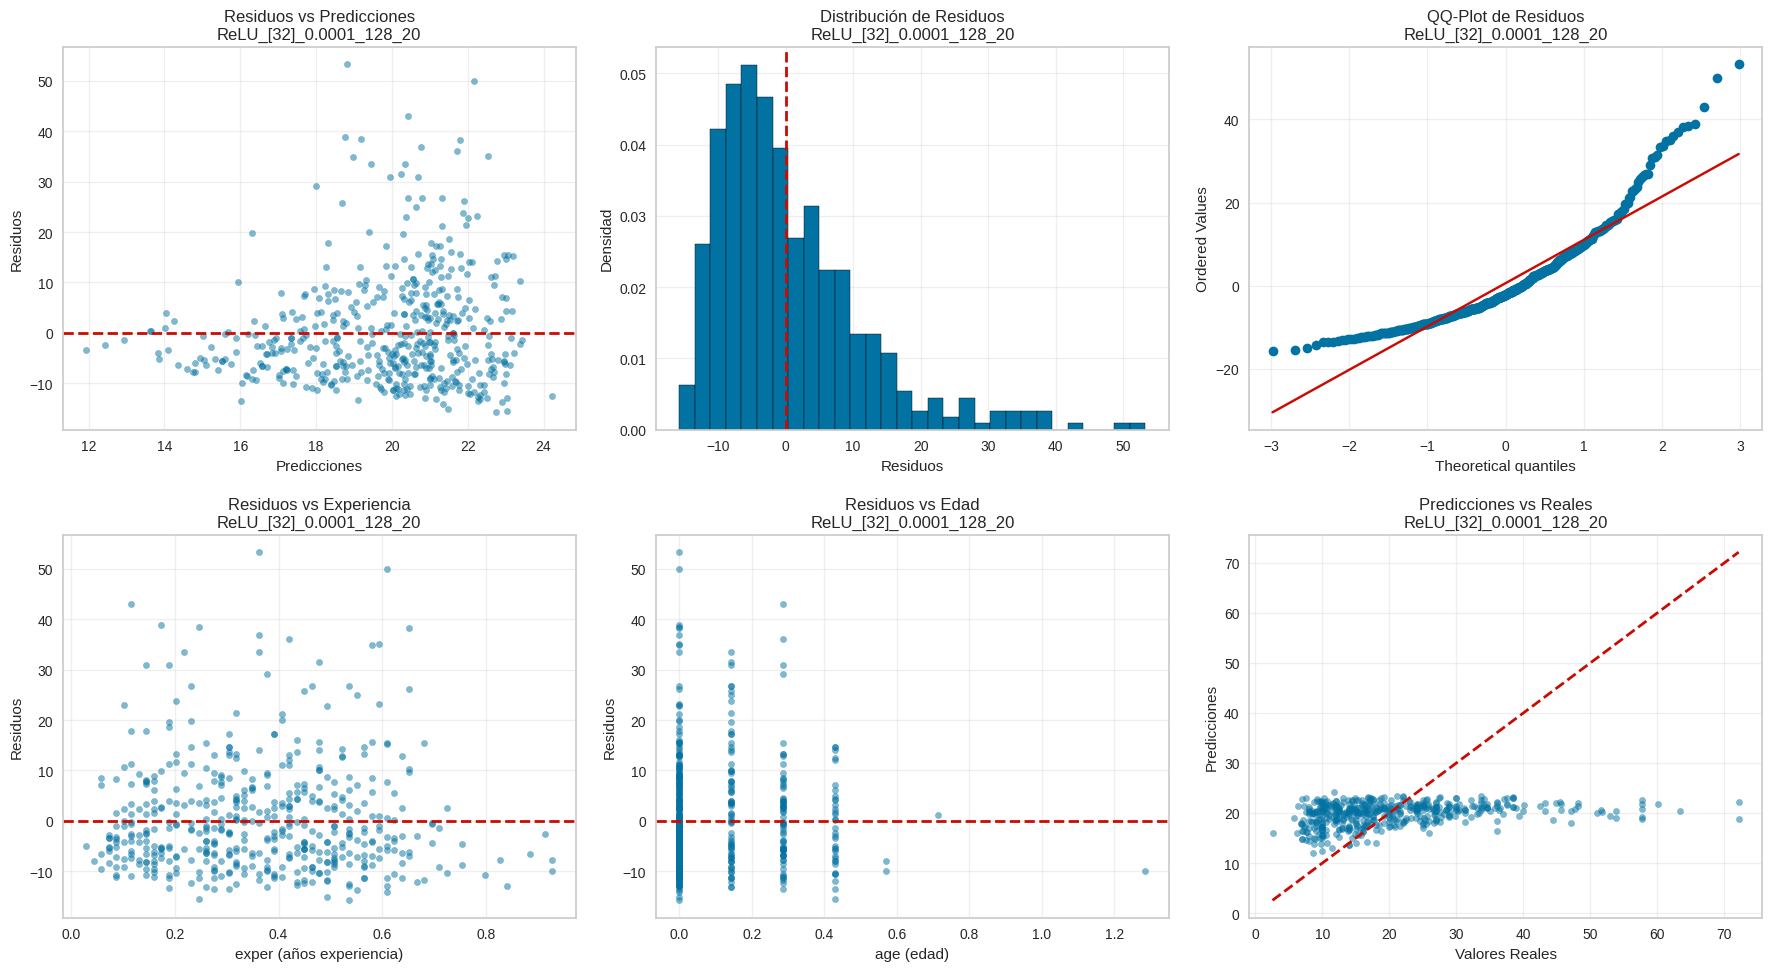


ESTADÍSTICAS DE RESIDUOS - ReLU_[32]_0.0001_128_20:
Media de residuos: 0.6045
Desviación estándar de residuos: 11.0400
Máximo residuo: 53.3031
Mínimo residuo: -15.7585
Residuos positivos: 203/484
Residuos negativos: 281/484


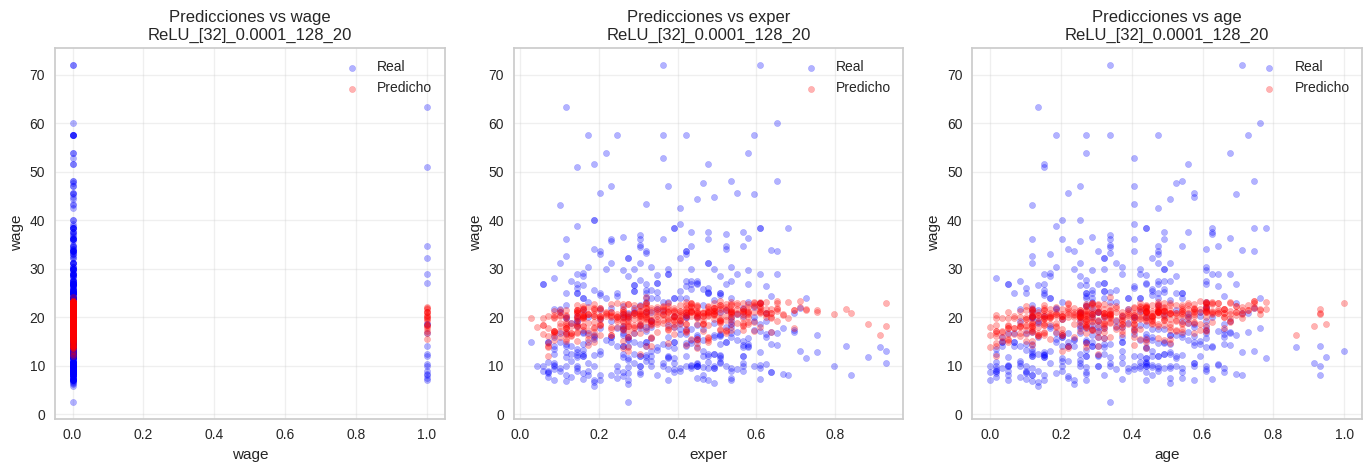

=== MODELO HETEROCEDÁSTICO ===


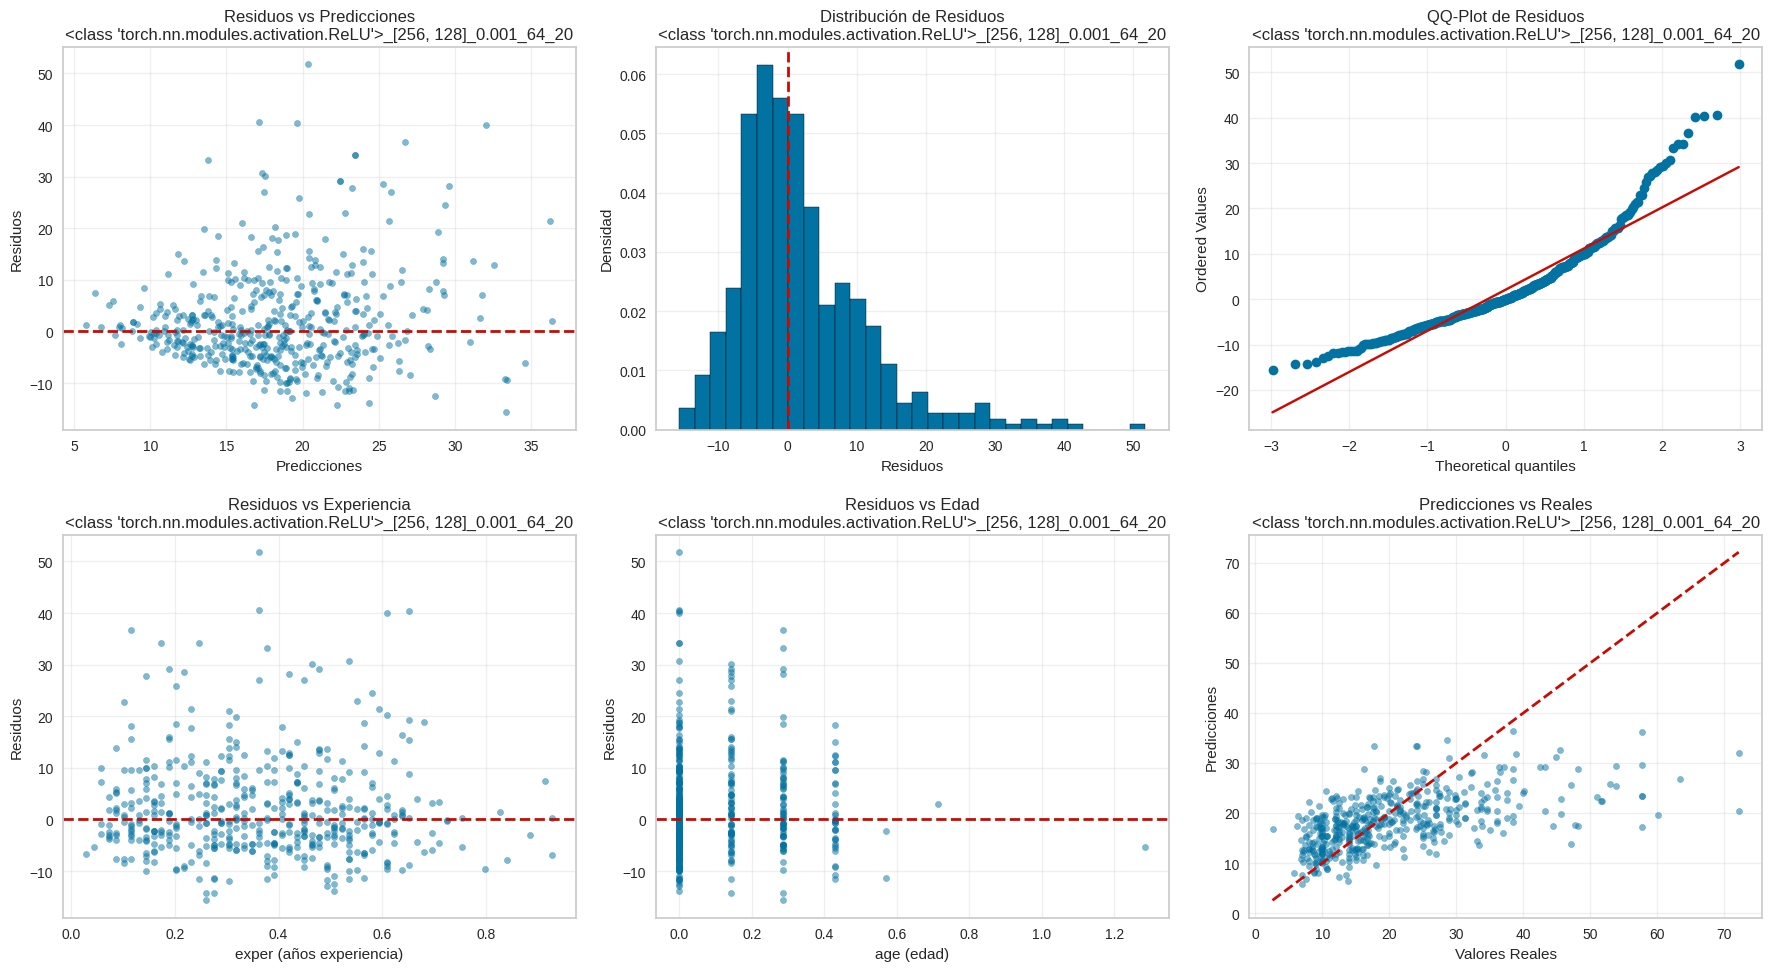


ESTADÍSTICAS DE RESIDUOS - <class 'torch.nn.modules.activation.ReLU'>_[256, 128]_0.001_64_20:
Media de residuos: 2.0820
Desviación estándar de residuos: 9.5385
Máximo residuo: 51.7946
Mínimo residuo: -15.6603
Residuos positivos: 242/484
Residuos negativos: 242/484


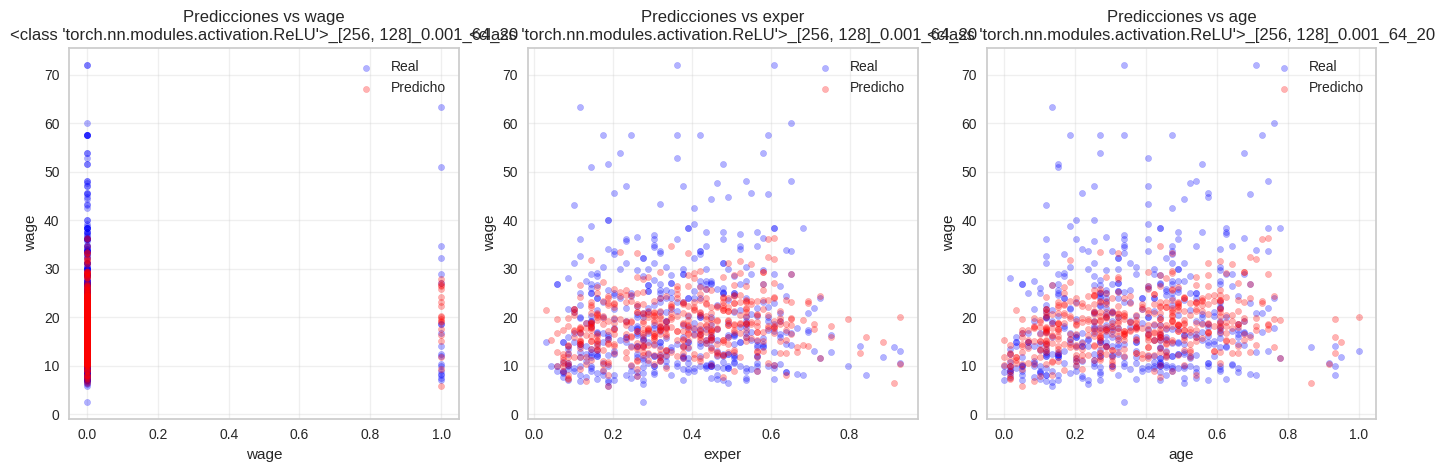

In [33]:
print("=== MODELO HOMOCEDÁSTICO ===")
plot_residuals(best_homo_info['y_true_val'], best_homo_info['y_pred_val'].flatten(), best_homo_name, X_validation_sc)
plot_predictions_vs_variables(X_validation_sc, best_homo_info['y_true_val'], best_homo_info['y_pred_val'].flatten(), best_homo_name, ['wage', 'exper', 'age'])

print("=== MODELO HETEROCEDÁSTICO ===")
plot_residuals(best_hetero_info['y_true_val'], best_hetero_info['y_pred_val'].flatten(), best_hetero_name, X_validation_sc)
plot_predictions_vs_variables(X_validation_sc, best_hetero_info['y_true_val'], best_hetero_info['y_pred_val'].flatten(), best_hetero_name, ['wage', 'exper', 'age'])

Los residuos del modelo homocedástico muestran una dispersión relativamente constante a lo largo del rango de predicciones, aunque se observa cierta tendencia a aumentar ligeramente en valores altos de las variables predictoras. En contraste, el modelo heterocedástico presenta una variabilidad de residuos más controlada, con patrones de dispersión que sugieren una mejor captura de la heterogeneidad en la varianza de los errores. Los residuos del segundo modelo están más concentrados alrededor de cero en todo el dominio, indicando una especificación más adecuada de la estructura de varianza.

El modelo homocedástico tiende a subestimar ligeramente los valores más altos de la variable objetivo, evidenciado por una mayor concentración de puntos por debajo de la línea de perfecta predicción en la región de valores elevados. El modelo heterocedástico corrige parcialmente este sesgo, produciendo predicciones más balanceadas a lo largo de todo el rango, especialmente en los extremos de la distribución. Cabe destacar que el modelo homocedástico solo predice valores entre 10 y 25 para $wage$, mientras que el modelo heterocedástico predice un mayor rango de valores.

Para la variable exper (experiencia), ambos modelos no acaban de capturar la relación positiva esperada. El modelo homocedástico muestra una relación más lineal, mientras que los valores predichos por el modelo heterocedástico están más dispersos, asemejándose más a los valores reales.

Respecto a age (edad) ocurre lo mismo: ambos modelos no acaban de capturar la relación positiva esperada. El modelo homocedástico muestra una relación más lineal, mientras que los valores predichos por el modelo heterocedástico están más dispersos, asemejándose más a los valores reales.

El modelo heterocedástico demuestra superioridad en varios aspectos: maneja mejor la variabilidad no constante de los errores y proporciona predicciones más equilibradas en todo el rango de la variable dependiente. Estas diferencias sugieren que la heterocedasticidad es un aspecto importante en estos datos y que su modelización explícita conduce a predicciones más precisas, especialmente en los valores situados en los extremos de las distribuciones.

## d)
### En el apartado anterior al ajustar la red hemos obtenido también la varianza de la predicción de la variable objetivo (el segundo valor que predice la red). Representa la varianza que se predice para el conjunto de test respecto al valor de la variable objetivo (fíjate en lo que predice la red en este segundo valor según lo que has respondido sobre el cálculo de la log verosimilitud). Comenta la relación entre los valores de la variable objetivo y la varianza predicha.

Text(0.5, 0, 'Desviación estándar predicha')

Text(0, 0.5, 'Error absoluto real')

Text(0.5, 1.0, "Predicción de la incertidumbre\n<class 'torch.nn.modules.activation.ReLU'>_[256, 128]_0.001_32_20")

Text(0.5, 0, 'Valor real (wage)')

Text(0, 0.5, 'Desviación estándar predicha')

Text(0.5, 1.0, "Incertidumbre vs Valor Real\n<class 'torch.nn.modules.activation.ReLU'>_[256, 128]_0.001_32_20")

(array([0.01027332, 0.02568331, 0.0410933 , 0.08218658, 0.04366165,
        0.11300655, 0.09502829, 0.09759656, 0.1232798 , 0.07705001,
        0.09502823, 0.07704992, 0.07191326, 0.06934501, 0.0590716 ,
        0.02568331, 0.0333883 , 0.01797831, 0.01284165, 0.01797831,
        0.00770499, 0.00770499, 0.00513666, 0.00513666, 0.01027332,
        0.00513666, 0.00513667, 0.00256833, 0.00256833, 0.00256833]),
 array([ 1.31365693,  2.11811543,  2.9225738 ,  3.72703218,  4.5314908 ,
         5.33594894,  6.14040756,  6.9448657 ,  7.74932432,  8.55378342,
         9.35824108, 10.1626997 , 10.96715832, 11.77161694, 12.5760746 ,
        13.38053322, 14.18499184, 14.98945045, 15.79390907, 16.59836769,
        17.40282631, 18.20728493, 19.01174355, 19.81620216, 20.62066078,
        21.4251194 , 22.22957802, 23.03403473, 23.83849335, 24.64295197,
        25.44741058]),
 <BarContainer object of 30 artists>)

Text(0.5, 0, 'Desviación estándar predicha')

Text(0, 0.5, 'Densidad')

Text(0.5, 1.0, "Distribución de Incertidumbre Predicha\n<class 'torch.nn.modules.activation.ReLU'>_[256, 128]_0.001_32_20")

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, '±1 std (68% ideal)'), Text(1, 0, '±2 std (95% ideal)')]

Text(0, 0.5, 'Porcentaje (%)')

Text(0.5, 1.0, "Calibración de Incertidumbre\n<class 'torch.nn.modules.activation.ReLU'>_[256, 128]_0.001_32_20")

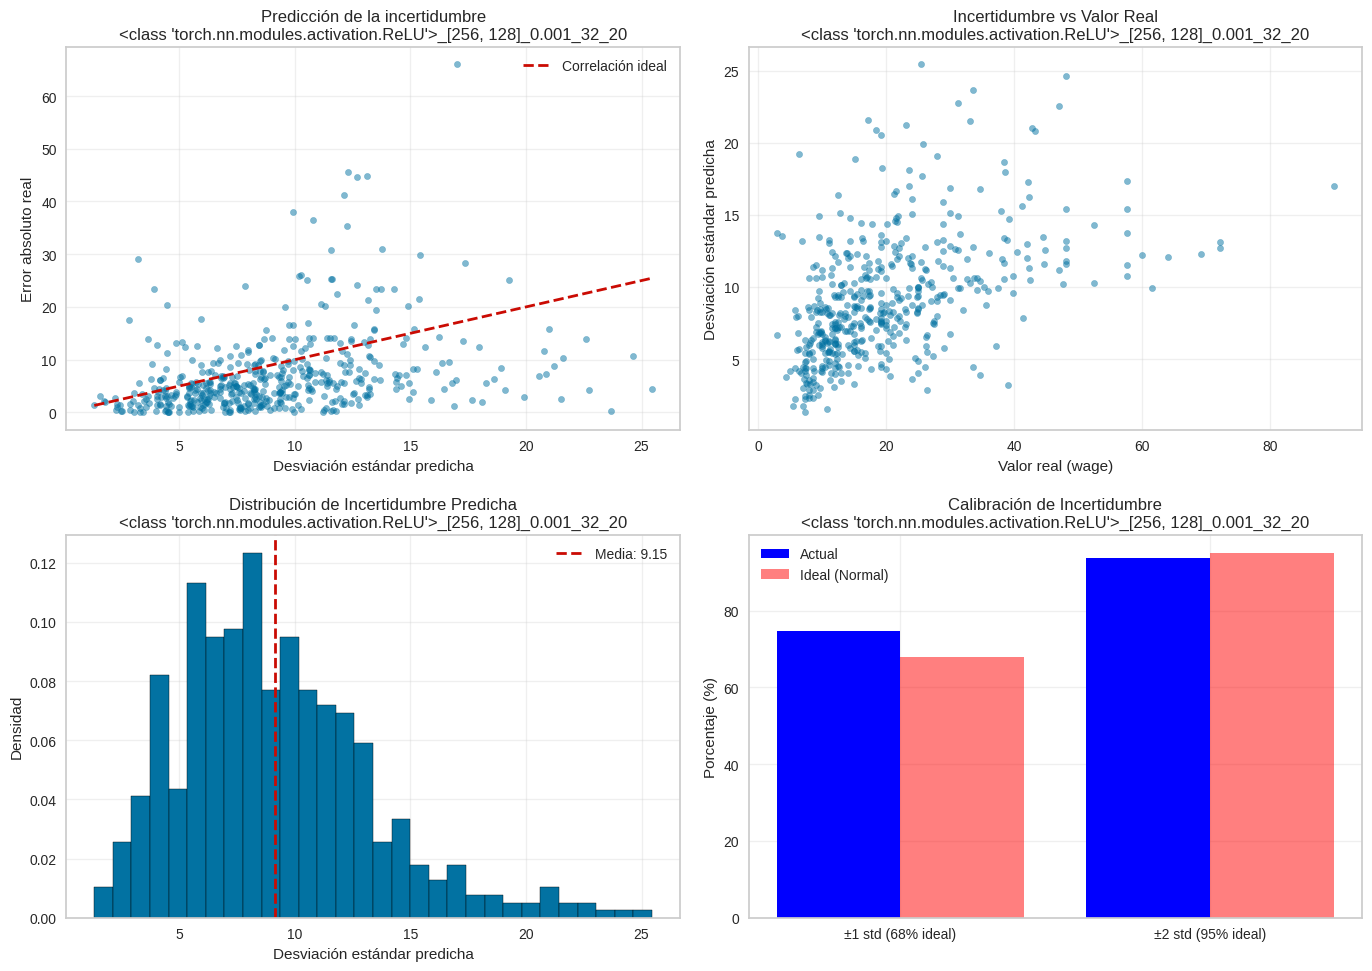


ANÁLISIS VARIANZA-ERROR - <class 'torch.nn.modules.activation.ReLU'>_[256, 128]_0.001_32_20:
Correlación σ predicha vs error absoluto: 0.319
Correlación σ predicha vs wage real: 0.494
Puntos dentro de ±1 std: 74.8% (ideal 68%)
Puntos dentro de ±2 std: 93.8% (ideal 95%)
✅ Calibración razonable


In [35]:
y_true = best_hetero_info['y_true_test']
y_pred = best_hetero_info['y_pred_test']
abs_error = np.abs(y_true - y_pred[:, 0])
pred_std = np.sqrt(np.exp(y_pred[:, 1]))
fig, axes = plt.subplots(2, 2, figsize = (14, 10))

# varianza vs EA
axes[0, 0].scatter(pred_std, abs_error, alpha = 0.5, s = 20)
axes[0, 0].set_xlabel('Desviación estándar predicha')
axes[0, 0].set_ylabel('Error absoluto real')
axes[0, 0].set_title('Predicción de la incertidumbre\n' + model_name)
axes[0, 0].grid(True, alpha = 0.3)
# Línea de correlación ideal
x_range = np.linspace(pred_std.min(), pred_std.max(), 100)
axes[0, 0].plot(x_range, x_range, 'r--', linewidth = 2, label = 'Correlación ideal')
axes[0, 0].legend()

# varianza vs wage
axes[0, 1].scatter(y_true, pred_std, alpha = 0.5, s = 20)
axes[0, 1].set_xlabel('Valor real (wage)')
axes[0, 1].set_ylabel('Desviación estándar predicha')
axes[0, 1].set_title('Incertidumbre vs Valor Real\n' + model_name)
axes[0, 1].grid(True, alpha = 0.3)

# histograma de desviaciones predichas
axes[1, 0].hist(pred_std, bins = 30, edgecolor = 'black', density = True)
axes[1, 0].axvline(x = pred_std.mean(), color = 'r', linestyle = '--', linewidth = 2, label = f'Media: {pred_std.mean():.2f}')
axes[1, 0].set_xlabel('Desviación estándar predicha')
axes[1, 0].set_ylabel('Densidad')
axes[1, 0].set_title('Distribución de Incertidumbre Predicha\n' + model_name)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha = 0.3)

# % de puntos dentro de ±std?
dentro_1std = np.sum(abs_error <= pred_std)/len(y_true) * 100
dentro_2std = np.sum(abs_error <= 2*pred_std)/len(y_true) * 100
labels = ['±1 std (68% ideal)', '±2 std (95% ideal)']
actual = [dentro_1std, dentro_2std]
ideal = [68, 95]
x = np.arange(len(labels))
axes[1, 1].bar(x - 0.2, actual, width = 0.4, label = 'Actual', color = 'blue')
axes[1, 1].bar(x + 0.2, ideal, width = 0.4, label = 'Ideal (Normal)', color = 'red', alpha = 0.5)
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(labels)
axes[1, 1].set_ylabel('Porcentaje (%)')
axes[1, 1].set_title(f'Calibración de Incertidumbre\n{model_name}')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha = 0.3)

plt.tight_layout()
plt.show()

# Análisis estadístico
print(f"\nANÁLISIS VARIANZA-ERROR - {model_name}:")
print(f"Correlación σ predicha vs error absoluto: {np.corrcoef(pred_std, abs_error)[0,1]:.3f}")
print(f"Correlación σ predicha vs wage real: {np.corrcoef(pred_std, y_true)[0,1]:.3f}")
print(f"Puntos dentro de ±1 std: {dentro_1std:.1f}% (ideal 68%)")
print(f"Puntos dentro de ±2 std: {dentro_2std:.1f}% (ideal 95%)")

if dentro_1std > 75:
    print("⚠️  La red puede ser demasiado conservadora (sobreestima incertidumbre)")
elif dentro_1std < 60:
    print("⚠️  La red puede ser demasiado confiada (subestima incertidumbre)")
else:
    print("✅ Calibración razonable")

La varianza representa la incertidumbre estimada por la red sobre su predicción media para cada punto del conjunto de test. Como esta es grande, la red considera que los puntos predecidos son dificiles, ruidosos o que no ha visto suficientes ejemplos parecidos.

Existe una correlación positiva entre la desviación estándar predicha y el error absoluto real, lo que indica que el modelo es capaz de cuantificar razonablemente bien su propia incertidumbre. Cuando predice alta variabilidad, efectivamente comete errores mayores, y viceversa. Sin embargo, la relación no es perfecta (no sigue exactamente la línea de correlación ideal): existe margen de mejora en la calibración de las incertidumbres.

Se observa una clara tendencia: a mayores valores de salario (wage), mayor es la incertidumbre predicha por el modelo. Esto refleja una heterocedasticidad de tipo proporcional, donde la variabilidad de los errores aumenta con la magnitud de la variable dependiente. Este patrón es común en datos económicos y justifica el uso de modelos que capturen explícitamente esta heterogeneidad en la varianza.

La distribución de las desviaciones estándar predichas muestra una forma un poco asimétrica con una cola hacia valores más altos. La mayoría de las predicciones tienen una incertidumbre moderada (valores alrededor de la media), pero existe un subconjunto de observaciones para las cuales el modelo predice una variabilidad sustancialmente mayor, típicamente asociadas a los salarios más elevados.

La evaluación de calibración revela que el modelo es ligeramente conservador en sus predicciones de incertidumbre. El porcentaje de puntos que caen dentro de ±1 desviación estándar predicha supera el valor teórico del 68% (ideal para una distribución normal), mientras que el porcentaje dentro de ±2 desviaciones estándar es un poco inferior al 95% teórico. Esto indica que el modelo tiende a estimar bastante bien la incertidumbre, proporcionando intervalos de predicción bastante precisos.

La capacidad del modelo heterocedástico para predecir tanto el valor esperado como la varianza condicional representa una ventaja significativa sobre el modelo homocedástico. Esta característica permite construir intervalos de predicción personalizados para cada observación, reconociendo que algunas predicciones son más confiables que otras. La relación identificada entre salarios altos y mayor incertidumbre es coherente con la realidad económica, donde los salarios elevados suelen presentar mayor dispersión debido a factores como la negociación individual, bonificaciones variables o características específicas del puesto.